## Main Jupyter Notebooks for implementing the German Traffic Sign Classification CNN

### Read in Data

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import os
import matplotlib.pyplot as plt

In [3]:
# Gibt an, ob wir auf einer GPU oder CPU trainieren 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
dataset = ImageFolder("GTSRB\Final_Training\Images", transform=transforms.ToTensor())
loader = DataLoader(dataset, batch_size=64, shuffle=False)

mean = 0.
std = 0.
total_images_count = 0

for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images_count += batch_samples

mean /= total_images_count
std /= total_images_count

print(f"Mean: {mean}")
print(f"Std: {std}")


Mean: tensor([0.3433, 0.3151, 0.3253])
Std: tensor([0.1690, 0.1713, 0.1815])


In [5]:
transform = transforms.Compose([
    transforms.Resize((35, 35)),  
    transforms.ToTensor(),
    # TODO: Schauen ob 0.5 überall besser ist oder ob selbst berechnete werte besser 
    transforms.Normalize(mean.tolist(), std.tolist()) 
    #transforms.Normalize((0.5,), (0.5,))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7489485..3.9978275].


Label: baustelle


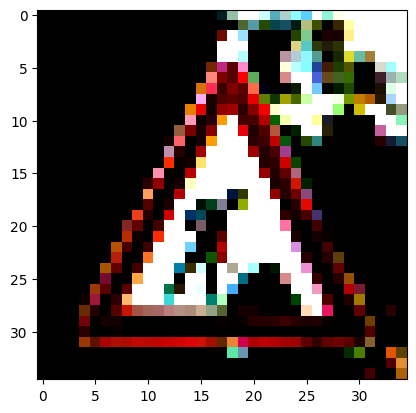

In [6]:
train_dataset = ImageFolder(root='GTSRB/Final_Training/Images', transform=transform)

test_dataset = ImageFolder(root='GTSRB/Final_Test/Images', transform=transform)

# Die Batchsize ist die Anzahl der Bilder, die auf einmal in das Netzwerk eingespeist werden. 
# Heißt es werden pro Trainingsschritt 64 Bilder durch das Netzwerk geschickt, dafür der Loss berechnet und dann für diesen Batch gemittelt, 
# anschließend werden die Parameter auf dem Durchschnittsgradienten aktualisiert.
batch_size = 64
test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
num_classes = 43
# --------- Testing ---------
img, label = test_dataset[3452]
label_string = test_dataset.classes[label]
print("Label:", label_string)
plt.imshow(img.permute(1, 2, 0))
#print(img)


### Create the Model

TODO: Über IMG Size sprechen (die meisten nutzen 32x32)

In [7]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=4, padding=1)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=4, padding=1)
        self.relu3 = nn.ReLU()

        self.conv_layer4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=4, padding=1)
        self.relu4 = nn.ReLU()

        self.conv_layer5 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=4, padding=1)
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.dropout6 = nn.Dropout(p=0.5)
        
        self.fc6 = nn.Linear(128, 512) 
        self.relu6 = nn.ReLU()
        self.dropout7 = nn.Dropout(p=0.5)  
        self.fc7 = nn.Linear(512, 256)
        self.relu7 = nn.ReLU()

        self.dropout8 = nn.Dropout(p=0.5)  
        self.fc8 = nn.Linear(256, 128)
        self.relu8 = nn.ReLU()

        self.fc9 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)

        out = self.conv_layer2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)

        out = self.conv_layer3(out)
        out = self.relu3(out)

        out = self.conv_layer4(out)
        out = self.relu4(out)

        out = self.conv_layer5(out)
        out = self.relu5(out)
        out = self.max_pool5(out)

        out = out.reshape(out.size(0), -1)
        out = self.dropout6(out)
        out = self.fc6(out)
        out = self.relu6(out)

        out = self.dropout7(out)
        out = self.fc7(out)
        out = self.relu7(out)

        out = self.dropout8(out)
        out = self.fc8(out)
        out = self.relu8(out)

        out = self.fc9(out)

        return out

In [19]:
# Initialisierung des Modells
model = CNN(num_classes).to(device)
loss_func = nn.CrossEntropyLoss()

# Initiale Lernrate und Optimizer
lr = 0.01
weight_decay = 0.001
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

# ReduceLROnPlateau Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=5, threshold=0.1)

In [13]:
def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the maximum value in the output
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
num_epochs = 40
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Save model
torch.save(model.state_dict(), 'model/40_epochs_self_normalized.pth')

### Test model with accuracy print

Epoch 1/100
Training Loss: 3.7123
Training Accuracy: 6.64%
Test Accuracy: 6.43%
Learning Rate: [0.01]


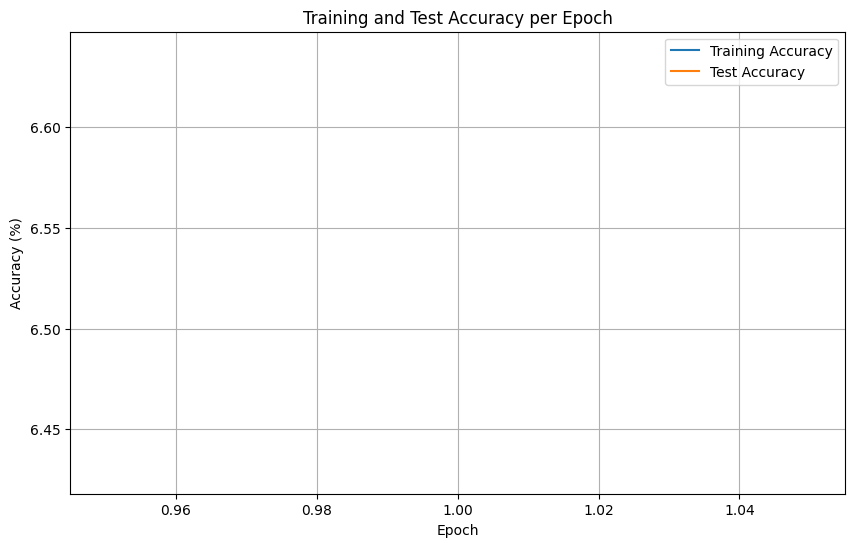

Epoch 2/100
Training Loss: 3.5366
Training Accuracy: 6.64%
Test Accuracy: 6.43%
Learning Rate: [0.01]


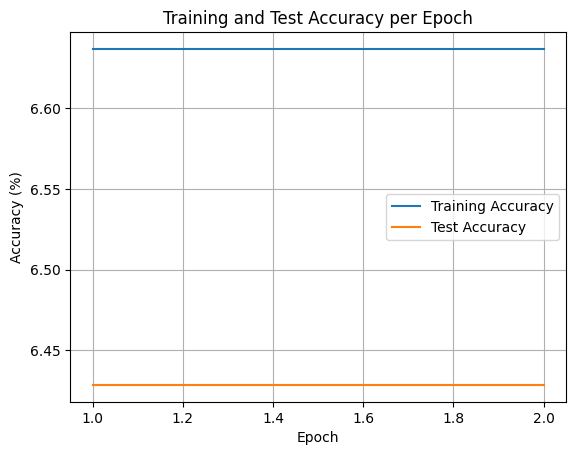

Epoch 3/100
Training Loss: 3.4750
Training Accuracy: 6.64%
Test Accuracy: 6.43%
Learning Rate: [0.01]


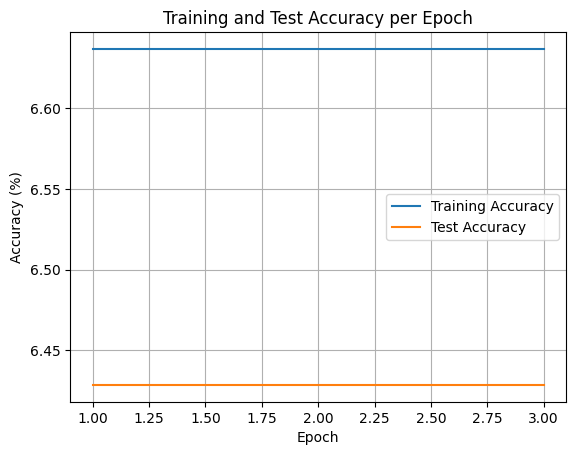

Epoch 4/100
Training Loss: 3.4042
Training Accuracy: 6.64%
Test Accuracy: 6.43%
Learning Rate: [0.01]


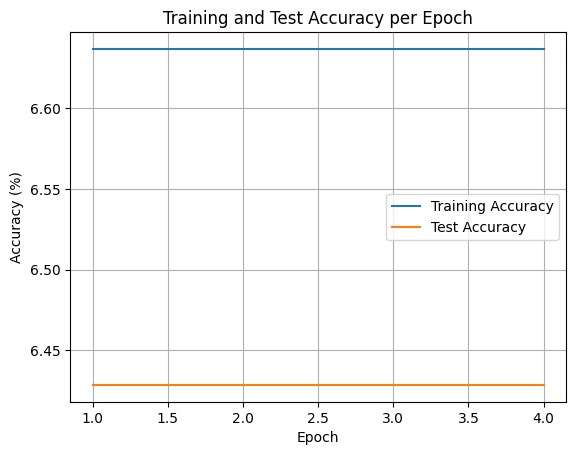

Epoch 5/100
Training Loss: 3.2889
Training Accuracy: 10.27%
Test Accuracy: 11.39%
Learning Rate: [0.01]


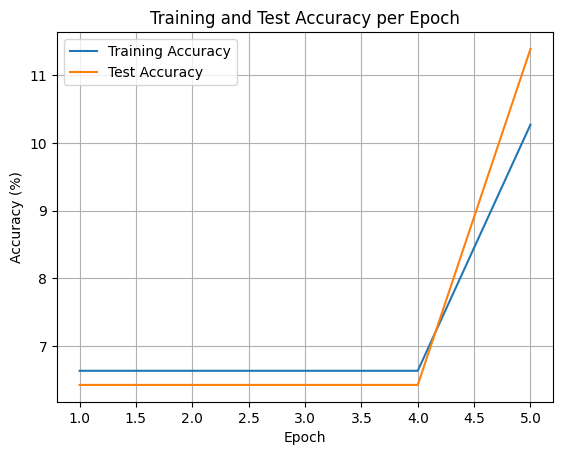

Epoch 6/100
Training Loss: 3.1710
Training Accuracy: 11.34%
Test Accuracy: 11.32%
Learning Rate: [0.01]


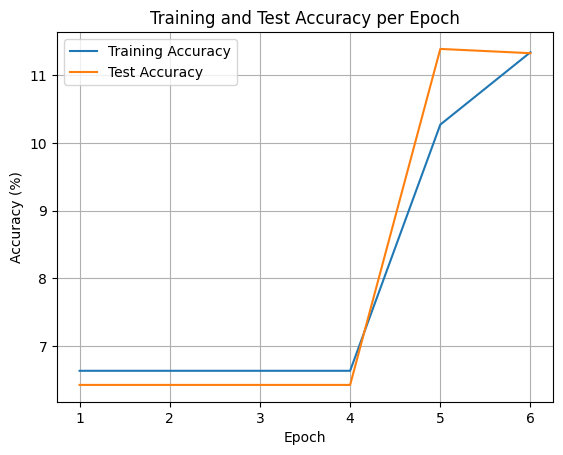

Epoch 7/100
Training Loss: 3.0970
Training Accuracy: 14.21%
Test Accuracy: 13.70%
Learning Rate: [0.01]


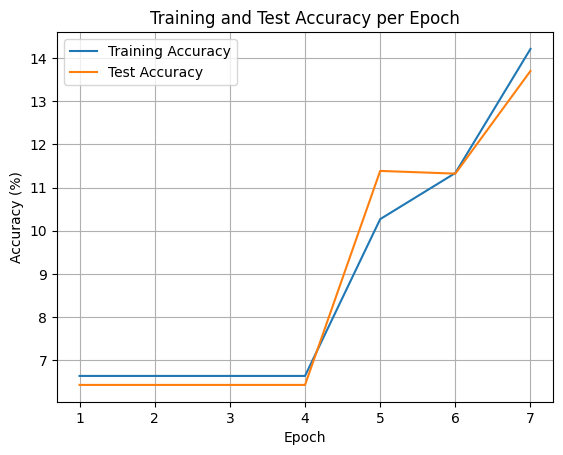

Epoch 8/100
Training Loss: 3.0255
Training Accuracy: 15.13%
Test Accuracy: 16.08%
Learning Rate: [0.01]


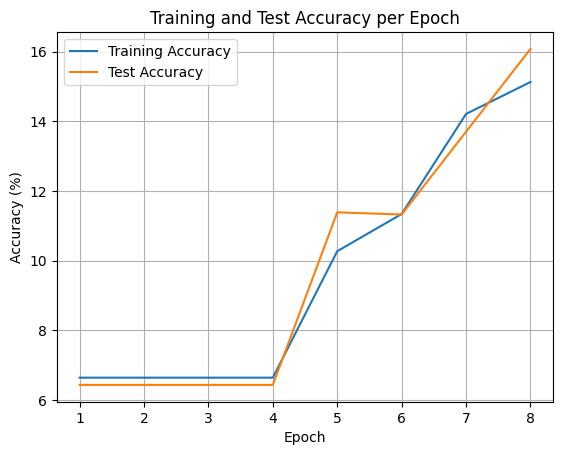

Epoch 9/100
Training Loss: 2.9568
Training Accuracy: 13.32%
Test Accuracy: 14.14%
Learning Rate: [0.01]


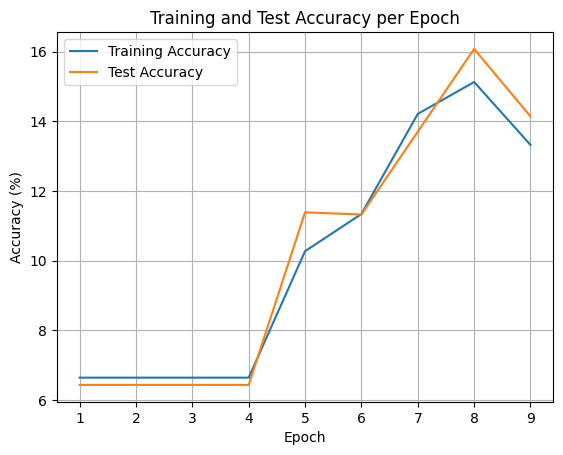

Epoch 10/100
Training Loss: 2.8997
Training Accuracy: 15.88%
Test Accuracy: 15.49%
Learning Rate: [0.01]


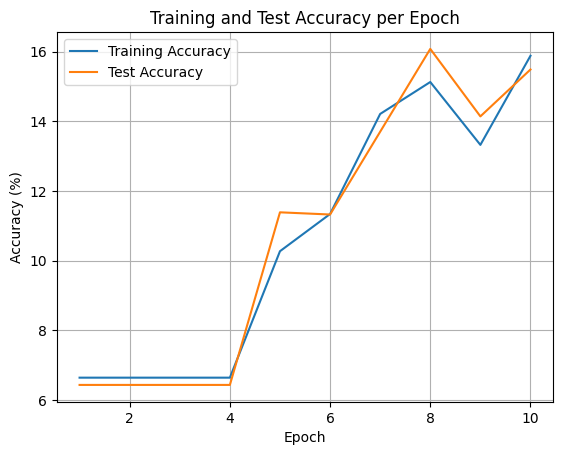

Epoch 11/100
Training Loss: 2.8424
Training Accuracy: 18.14%
Test Accuracy: 19.44%
Learning Rate: [0.01]


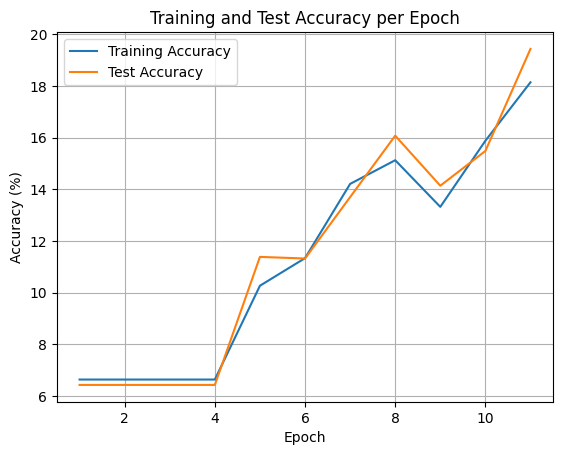

Epoch 12/100
Training Loss: 2.7882
Training Accuracy: 20.51%
Test Accuracy: 21.59%
Learning Rate: [0.01]


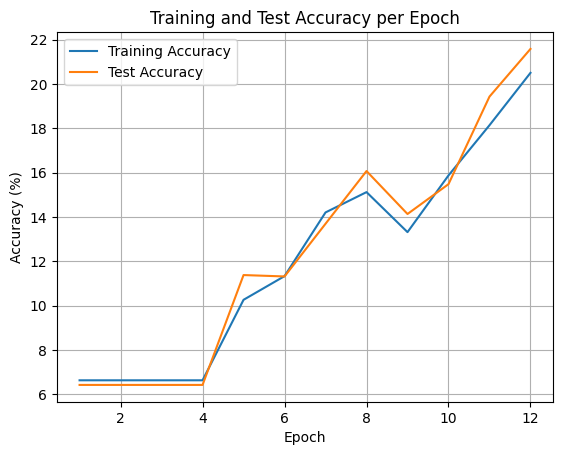

Epoch 13/100
Training Loss: 2.7365
Training Accuracy: 21.44%
Test Accuracy: 21.20%
Learning Rate: [0.01]


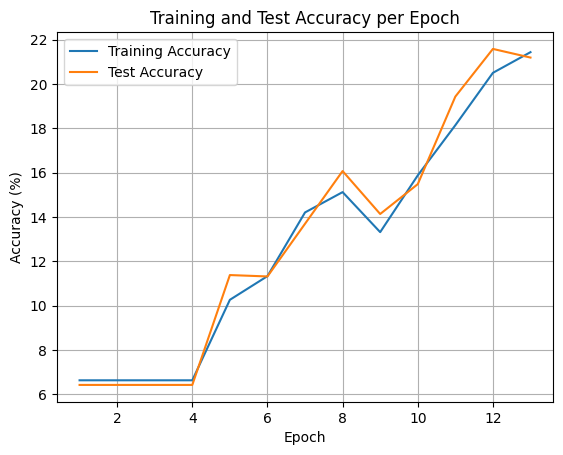

Epoch 14/100
Training Loss: 2.6818
Training Accuracy: 22.81%
Test Accuracy: 23.03%
Learning Rate: [0.01]


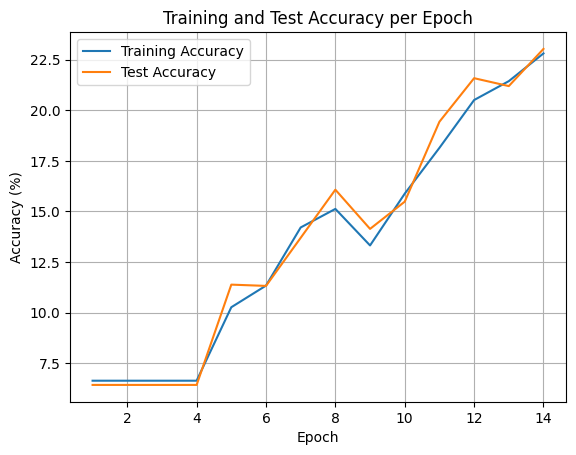

Epoch 15/100
Training Loss: 2.6074
Training Accuracy: 21.06%
Test Accuracy: 21.71%
Learning Rate: [0.01]


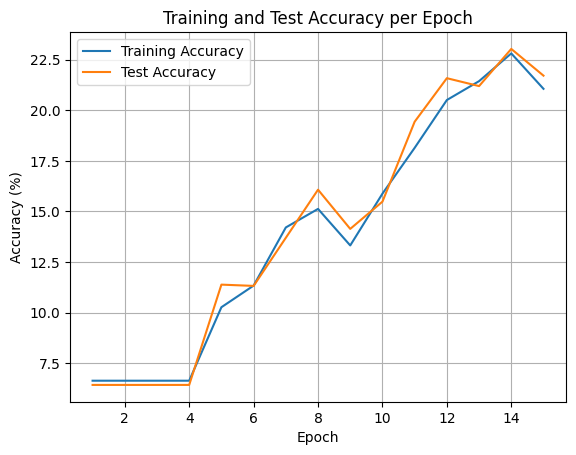

Epoch 16/100
Training Loss: 2.5088
Training Accuracy: 21.71%
Test Accuracy: 21.49%
Learning Rate: [0.01]


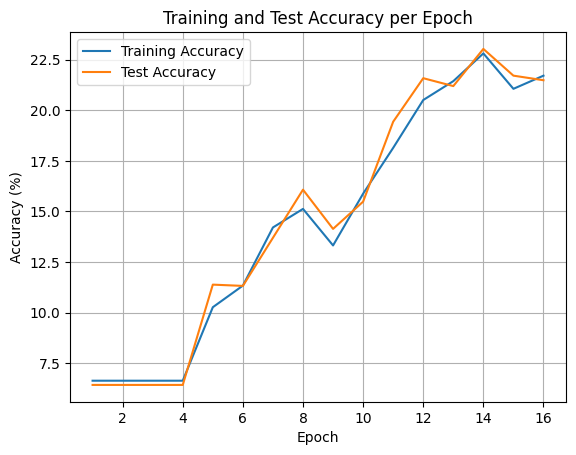

Epoch 17/100
Training Loss: 2.4087
Training Accuracy: 27.39%
Test Accuracy: 28.44%
Learning Rate: [0.01]


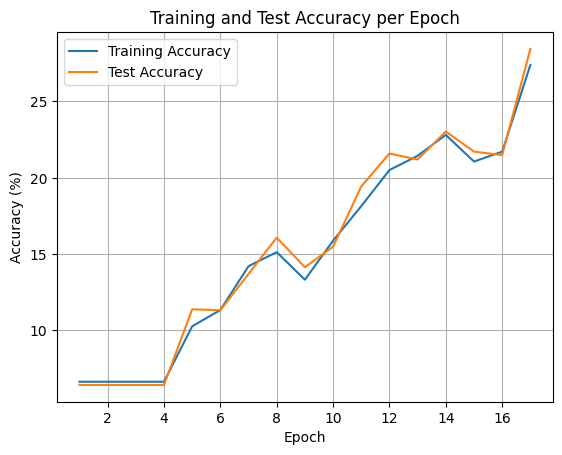

Epoch 18/100
Training Loss: 2.2892
Training Accuracy: 35.13%
Test Accuracy: 33.97%
Learning Rate: [0.01]


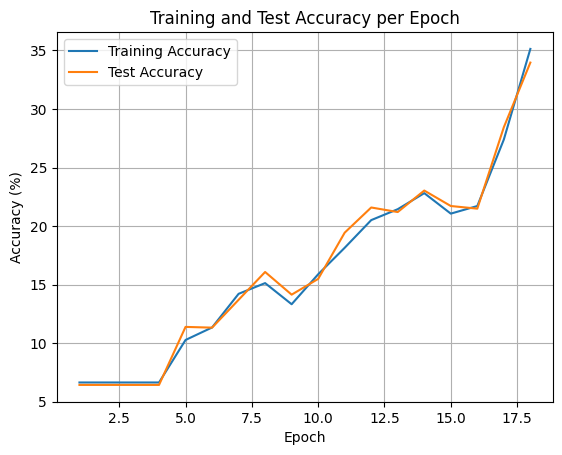

Epoch 19/100
Training Loss: 2.1711
Training Accuracy: 35.76%
Test Accuracy: 36.04%
Learning Rate: [0.01]


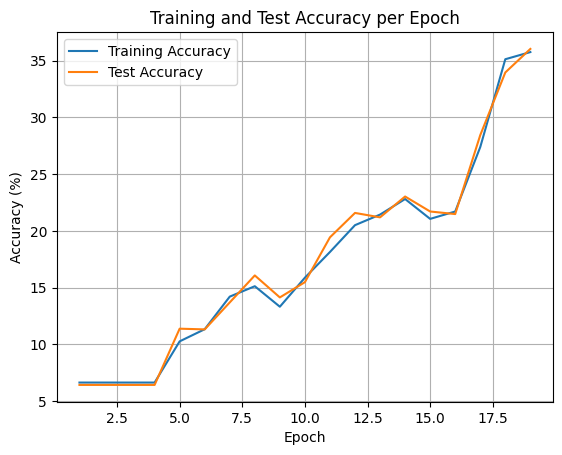

Epoch 20/100
Training Loss: 2.0859
Training Accuracy: 41.53%
Test Accuracy: 42.66%
Learning Rate: [0.01]


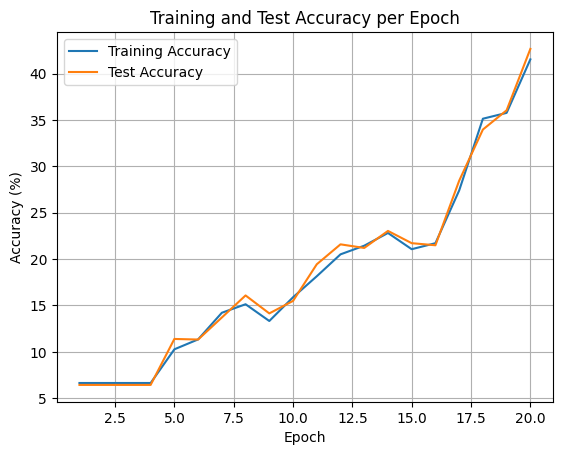

Epoch 21/100
Training Loss: 2.0132
Training Accuracy: 42.36%
Test Accuracy: 43.35%
Learning Rate: [0.01]


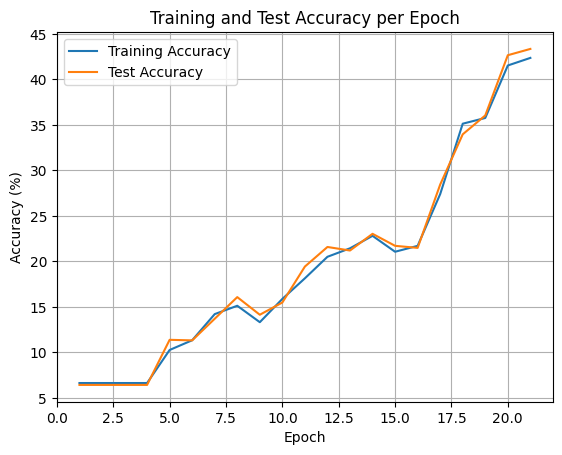

Epoch 22/100
Training Loss: 1.9069
Training Accuracy: 40.56%
Test Accuracy: 38.76%
Learning Rate: [0.01]


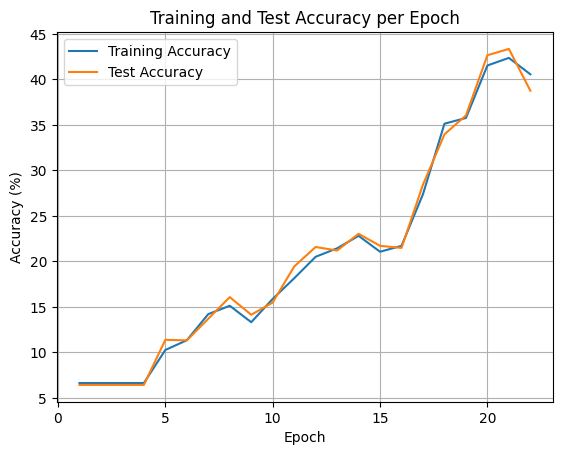

Epoch 23/100
Training Loss: 1.7965
Training Accuracy: 45.70%
Test Accuracy: 45.40%
Learning Rate: [0.01]


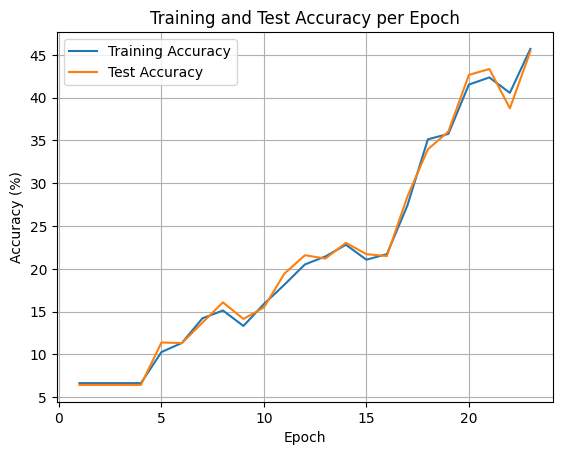

Epoch 24/100
Training Loss: 1.7008
Training Accuracy: 50.38%
Test Accuracy: 51.63%
Learning Rate: [0.01]


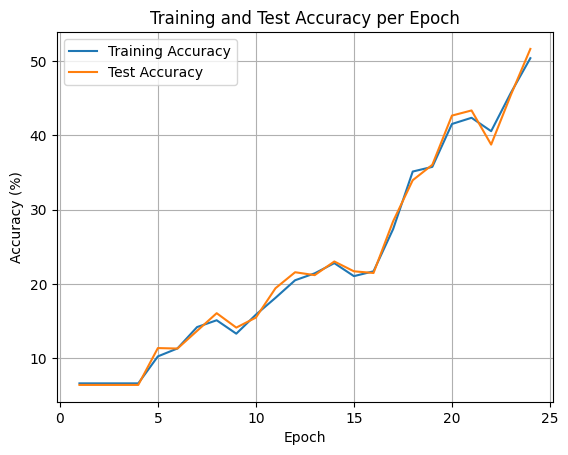

Epoch 25/100
Training Loss: 1.5919
Training Accuracy: 55.21%
Test Accuracy: 54.69%
Learning Rate: [0.01]


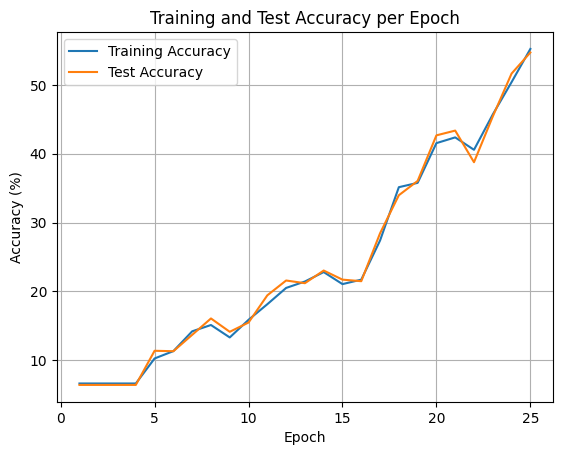

Epoch 26/100
Training Loss: 1.4841
Training Accuracy: 59.95%
Test Accuracy: 58.30%
Learning Rate: [0.01]


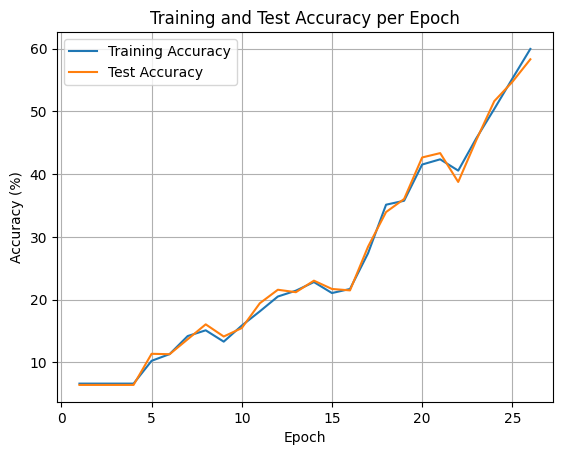

Epoch 27/100
Training Loss: 1.3750
Training Accuracy: 63.69%
Test Accuracy: 61.11%
Learning Rate: [0.01]


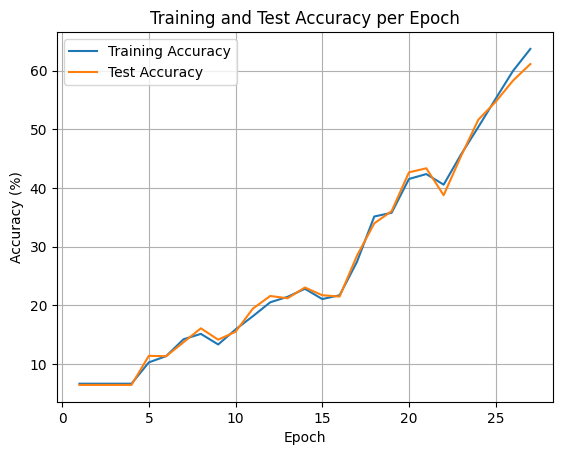

Epoch 28/100
Training Loss: 1.2579
Training Accuracy: 71.60%
Test Accuracy: 67.53%
Learning Rate: [0.01]


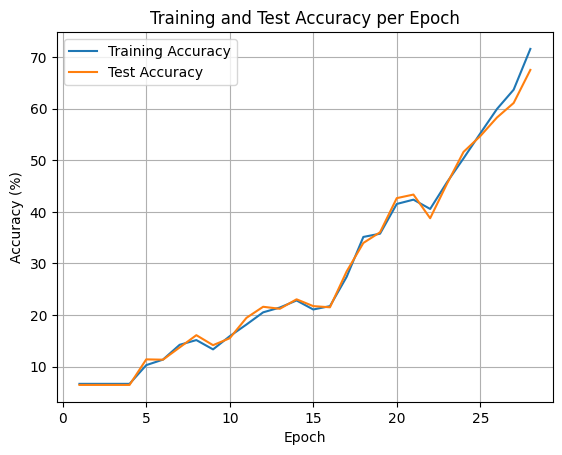

Epoch 29/100
Training Loss: 1.1279
Training Accuracy: 67.41%
Test Accuracy: 65.83%
Learning Rate: [0.01]


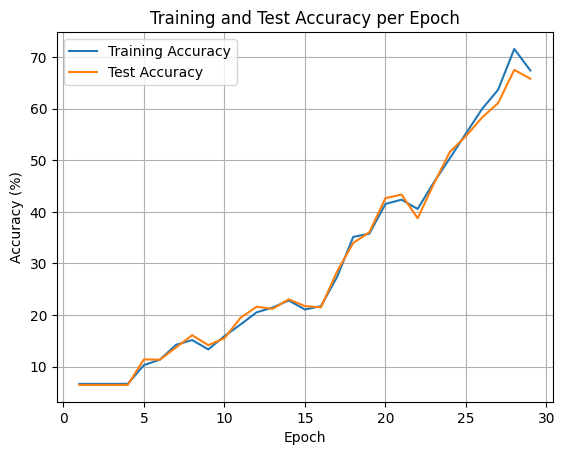

Epoch 30/100
Training Loss: 1.0179
Training Accuracy: 77.57%
Test Accuracy: 73.90%
Learning Rate: [0.01]


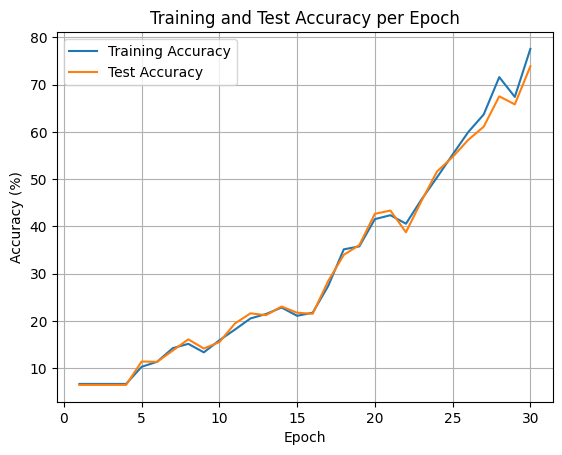

Epoch 31/100
Training Loss: 0.9011
Training Accuracy: 80.72%
Test Accuracy: 77.12%
Learning Rate: [0.01]


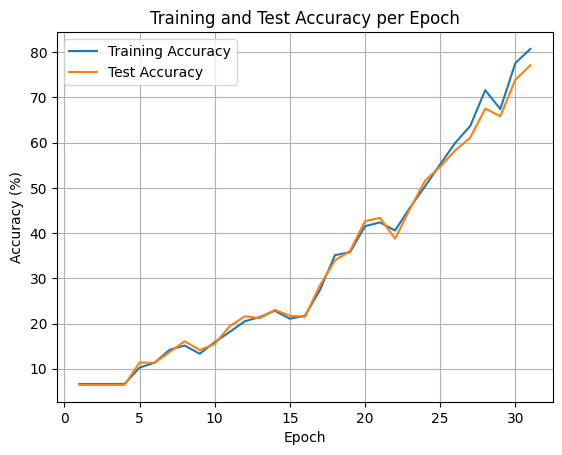

Epoch 32/100
Training Loss: 0.8229
Training Accuracy: 85.17%
Test Accuracy: 81.65%
Learning Rate: [0.01]


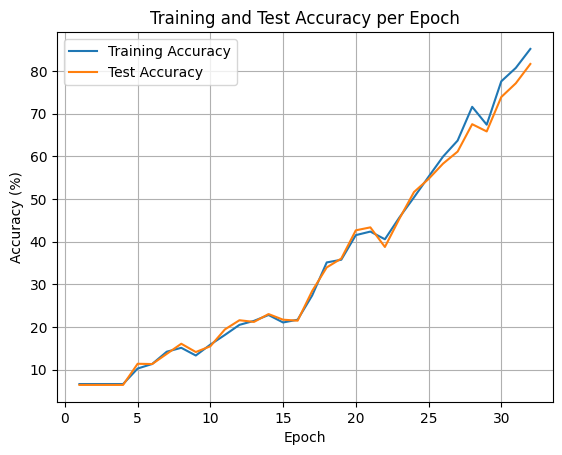

Epoch 33/100
Training Loss: 0.7398
Training Accuracy: 85.88%
Test Accuracy: 83.16%
Learning Rate: [0.01]


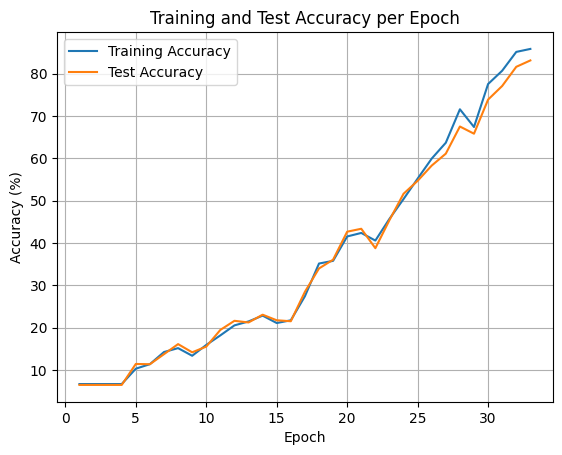

Epoch 34/100
Training Loss: 0.6591
Training Accuracy: 84.89%
Test Accuracy: 81.39%
Learning Rate: [0.01]


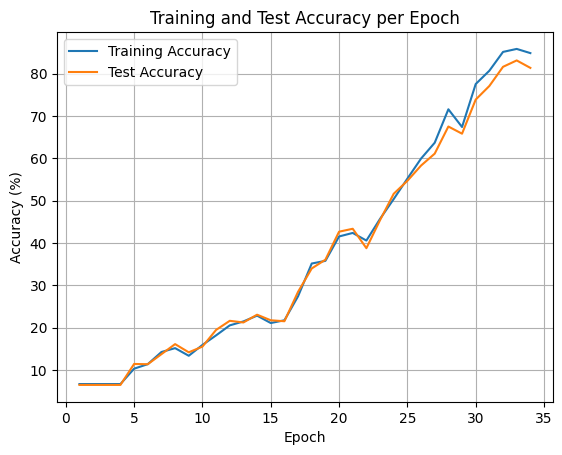

Epoch 35/100
Training Loss: 0.6079
Training Accuracy: 89.56%
Test Accuracy: 85.73%
Learning Rate: [0.01]


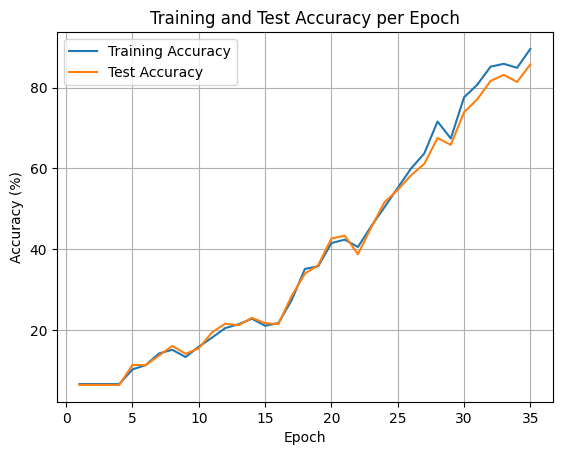

Epoch 36/100
Training Loss: 0.5596
Training Accuracy: 89.36%
Test Accuracy: 84.54%
Learning Rate: [0.01]


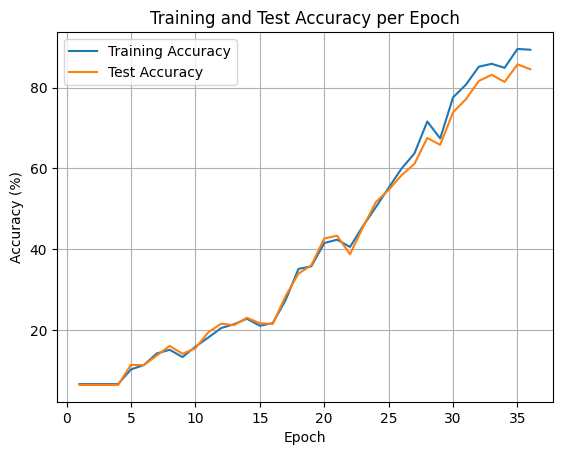

Epoch 37/100
Training Loss: 0.5111
Training Accuracy: 92.50%
Test Accuracy: 87.38%
Learning Rate: [0.01]


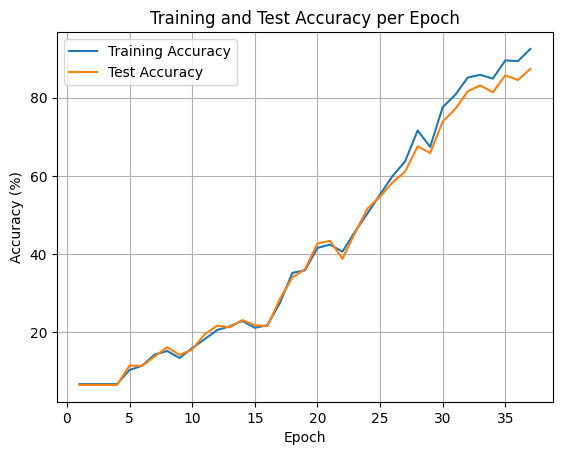

Epoch 38/100
Training Loss: 0.4718
Training Accuracy: 92.57%
Test Accuracy: 87.66%
Learning Rate: [0.01]


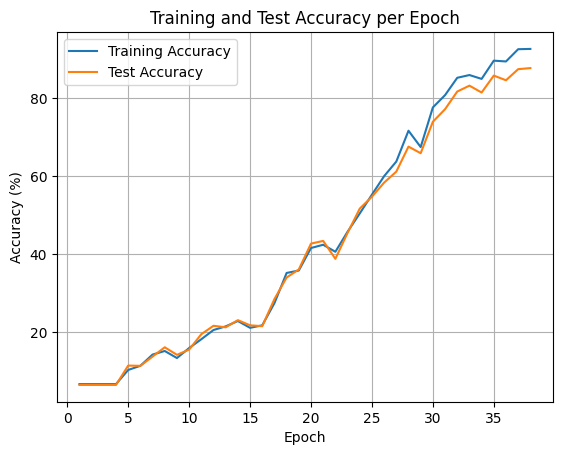

Epoch 39/100
Training Loss: 0.4486
Training Accuracy: 92.58%
Test Accuracy: 89.11%
Learning Rate: [0.01]


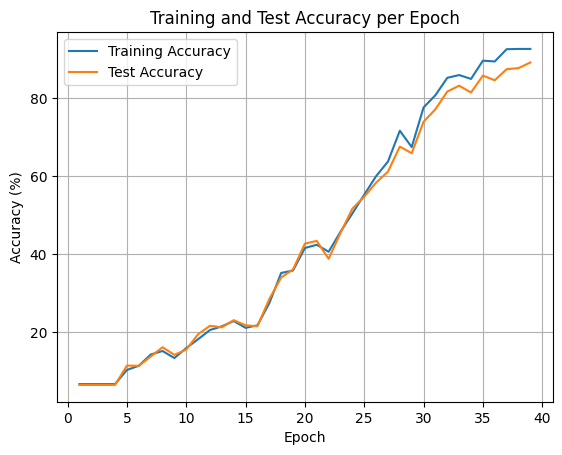

Epoch 40/100
Training Loss: 0.4237
Training Accuracy: 94.56%
Test Accuracy: 89.62%
Learning Rate: [0.01]


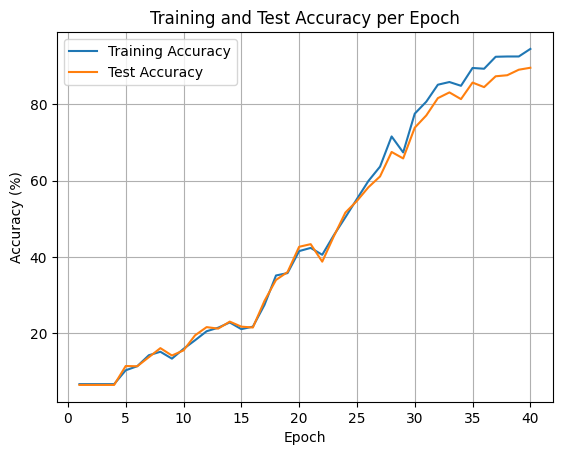

Epoch 41/100
Training Loss: 0.3972
Training Accuracy: 95.72%
Test Accuracy: 90.33%
Learning Rate: [0.01]


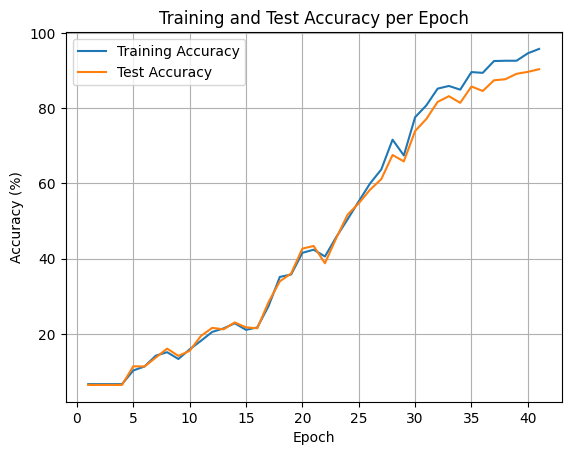

Epoch 42/100
Training Loss: 0.3683
Training Accuracy: 95.14%
Test Accuracy: 90.44%
Learning Rate: [0.01]


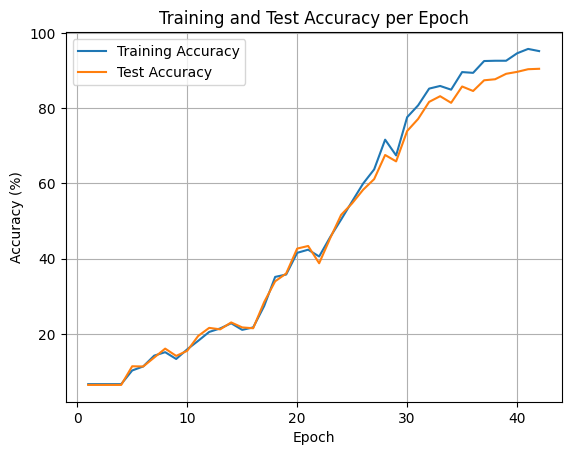

Epoch 43/100
Training Loss: 0.3549
Training Accuracy: 95.66%
Test Accuracy: 91.38%
Learning Rate: [0.01]


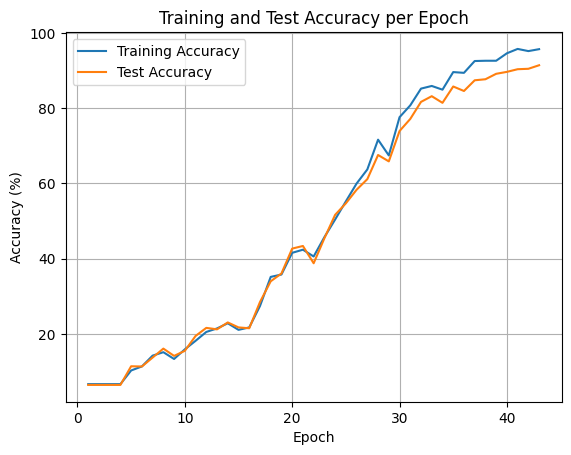

Epoch 44/100
Training Loss: 0.3426
Training Accuracy: 94.82%
Test Accuracy: 90.46%
Learning Rate: [0.01]


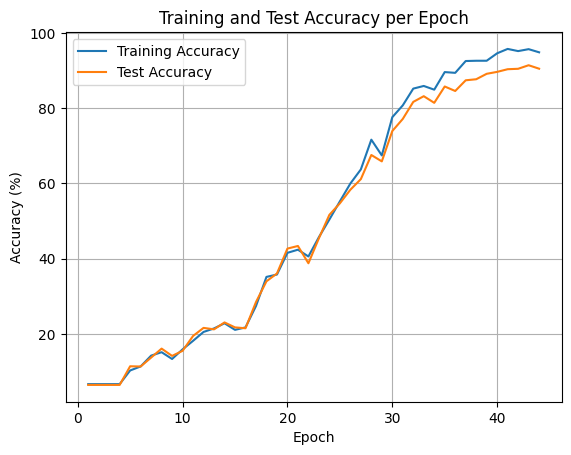

Epoch 45/100
Training Loss: 0.3215
Training Accuracy: 97.37%
Test Accuracy: 92.46%
Learning Rate: [0.01]


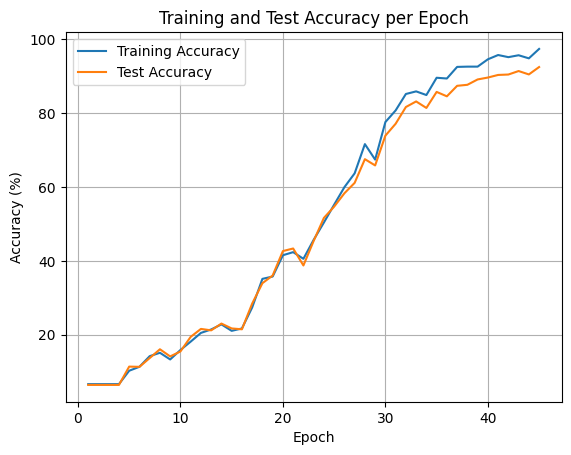

Epoch 46/100
Training Loss: 0.3034
Training Accuracy: 96.66%
Test Accuracy: 91.45%
Learning Rate: [0.01]


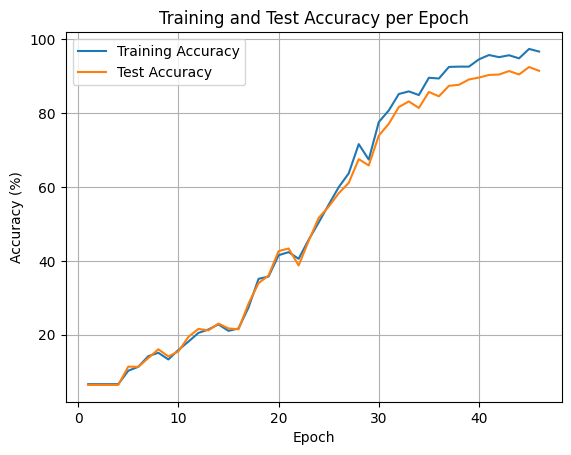

Epoch 47/100
Training Loss: 0.2965
Training Accuracy: 97.66%
Test Accuracy: 92.96%
Learning Rate: [0.01]


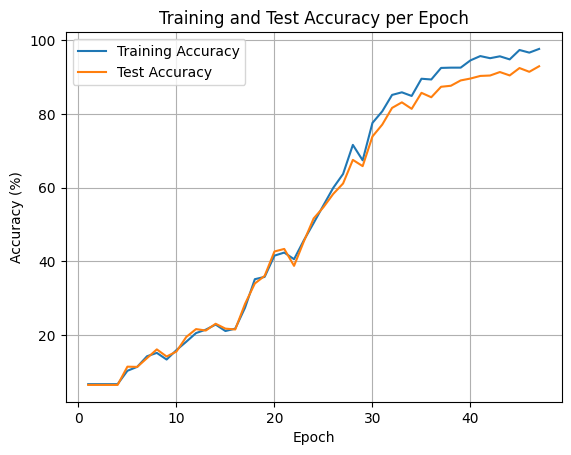

Epoch 48/100
Training Loss: 0.2799
Training Accuracy: 97.96%
Test Accuracy: 93.04%
Learning Rate: [0.01]


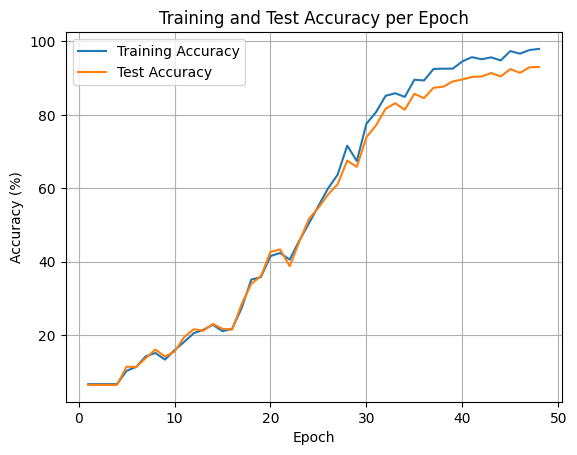

Epoch 49/100
Training Loss: 0.2648
Training Accuracy: 97.68%
Test Accuracy: 93.33%
Learning Rate: [0.01]


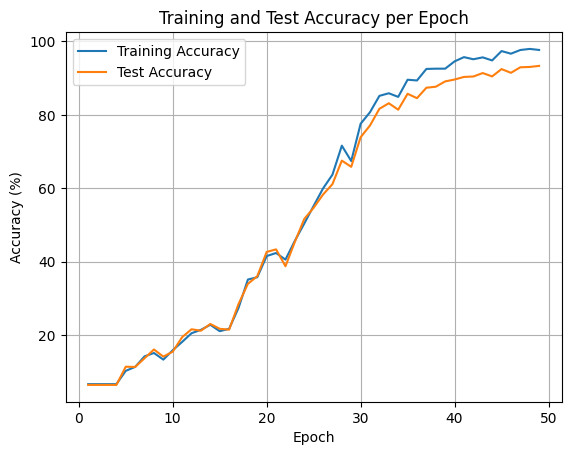

Epoch 50/100
Training Loss: 0.2620
Training Accuracy: 97.11%
Test Accuracy: 92.57%
Learning Rate: [0.01]


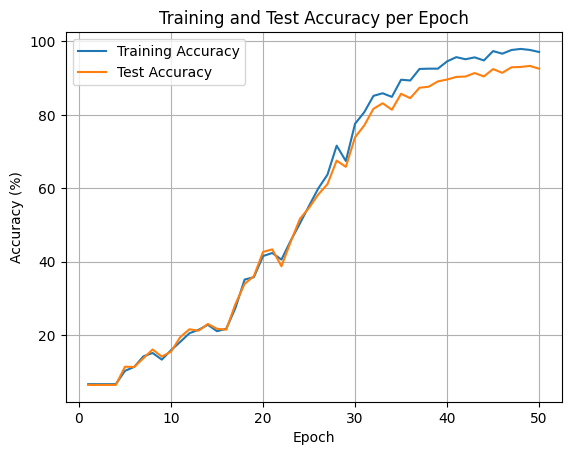

Epoch 51/100
Training Loss: 0.2444
Training Accuracy: 97.80%
Test Accuracy: 92.97%
Learning Rate: [0.01]


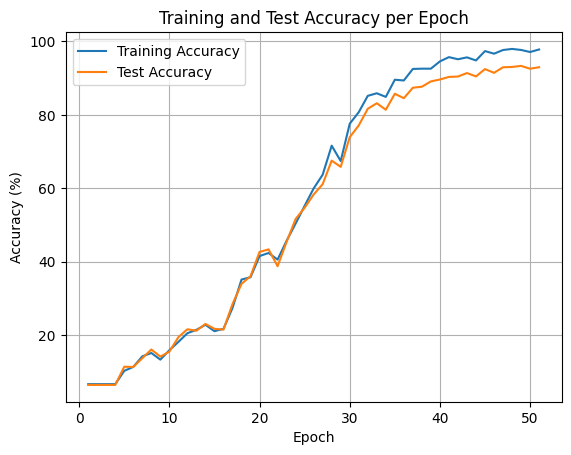

Epoch 52/100
Training Loss: 0.2394
Training Accuracy: 98.25%
Test Accuracy: 93.53%
Learning Rate: [0.01]


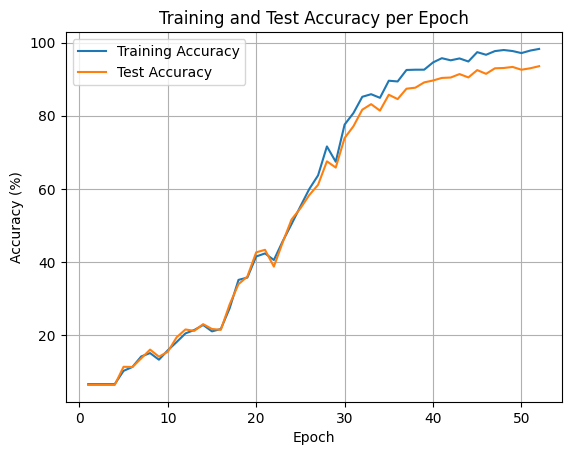

Epoch 53/100
Training Loss: 0.2281
Training Accuracy: 98.86%
Test Accuracy: 93.87%
Learning Rate: [0.01]


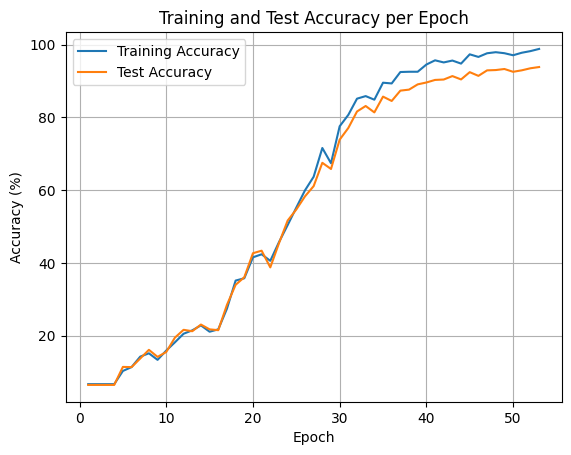

Epoch 54/100
Training Loss: 0.2132
Training Accuracy: 99.05%
Test Accuracy: 94.52%
Learning Rate: [0.01]


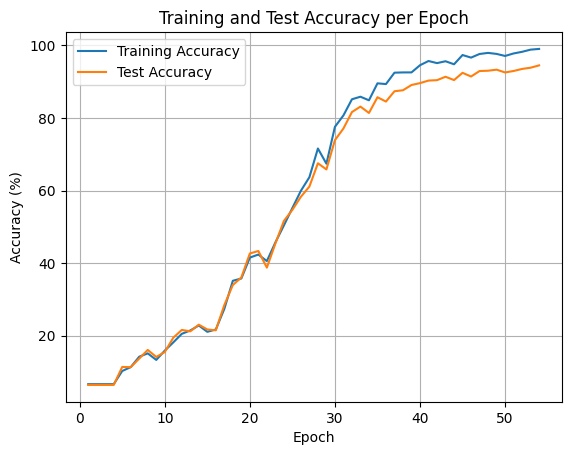

Epoch 55/100
Training Loss: 0.2174
Training Accuracy: 98.88%
Test Accuracy: 94.04%
Learning Rate: [0.01]


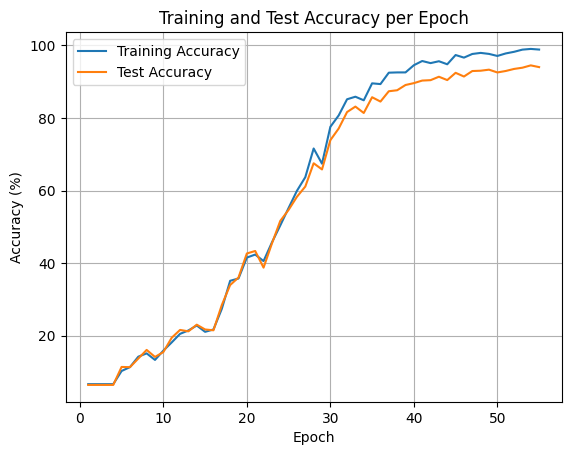

Epoch 56/100
Training Loss: 0.2028
Training Accuracy: 98.96%
Test Accuracy: 94.02%
Learning Rate: [0.01]


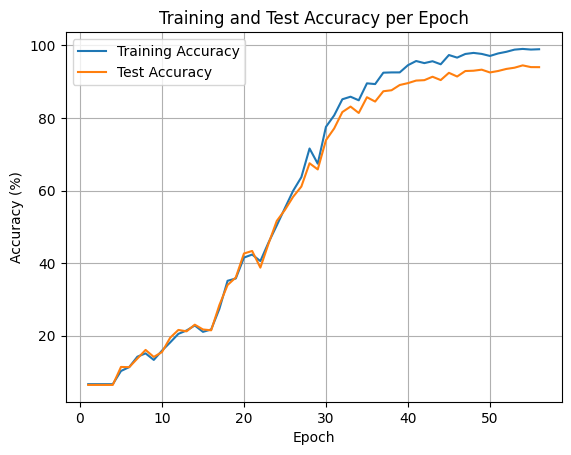

Epoch 57/100
Training Loss: 0.1986
Training Accuracy: 99.07%
Test Accuracy: 94.83%
Learning Rate: [0.01]


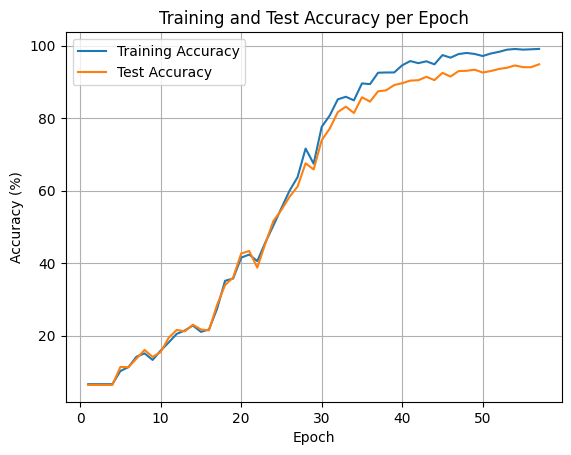

Epoch 58/100
Training Loss: 0.2025
Training Accuracy: 99.07%
Test Accuracy: 94.01%
Learning Rate: [0.01]


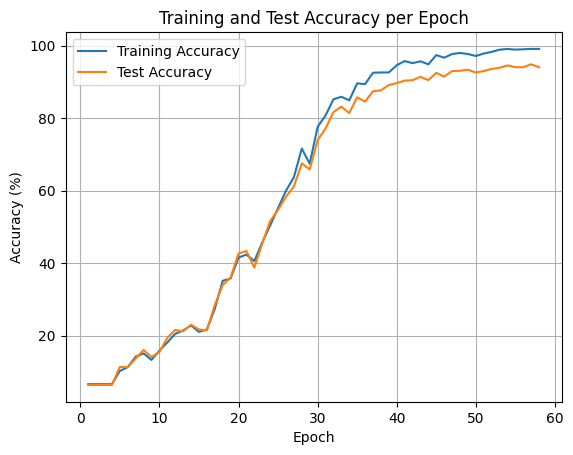

Epoch 59/100
Training Loss: 0.1873
Training Accuracy: 98.94%
Test Accuracy: 94.36%
Learning Rate: [0.01]


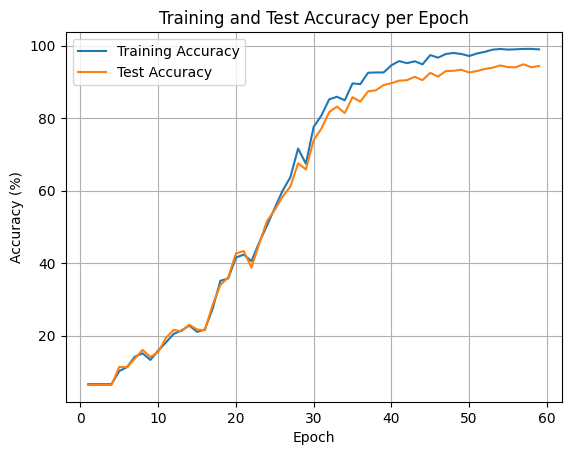

Epoch 60/100
Training Loss: 0.1814
Training Accuracy: 99.70%
Test Accuracy: 94.53%
Learning Rate: [0.01]


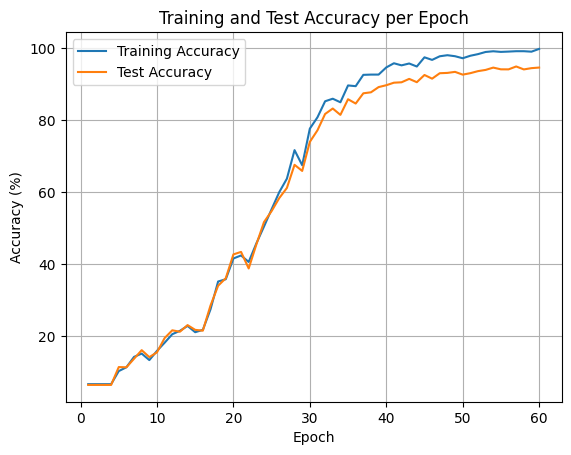

Epoch 61/100
Training Loss: 0.1725
Training Accuracy: 98.78%
Test Accuracy: 93.57%
Learning Rate: [0.01]


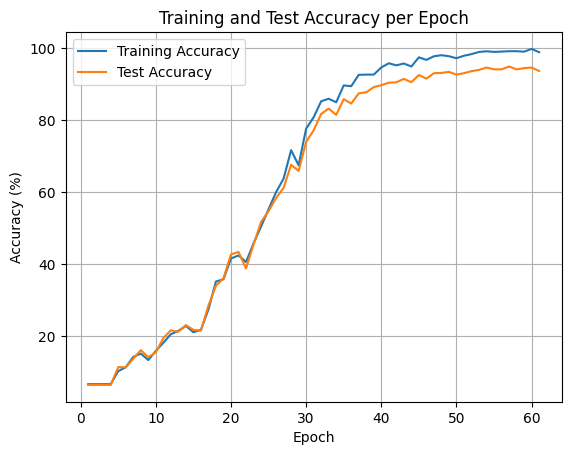

Epoch 62/100
Training Loss: 0.1657
Training Accuracy: 99.39%
Test Accuracy: 94.72%
Learning Rate: [0.01]


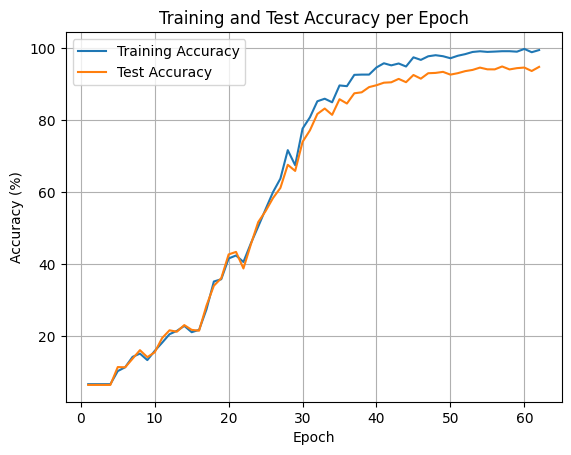

Epoch 63/100
Training Loss: 0.1646
Training Accuracy: 99.50%
Test Accuracy: 94.48%
Learning Rate: [0.01]


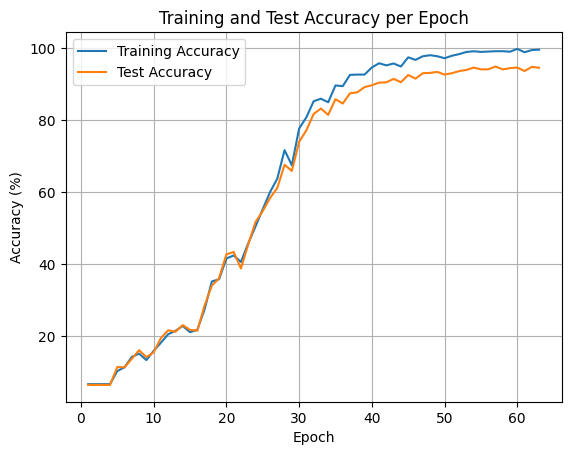

Epoch 64/100
Training Loss: 0.1611
Training Accuracy: 99.04%
Test Accuracy: 94.38%
Learning Rate: [0.01]


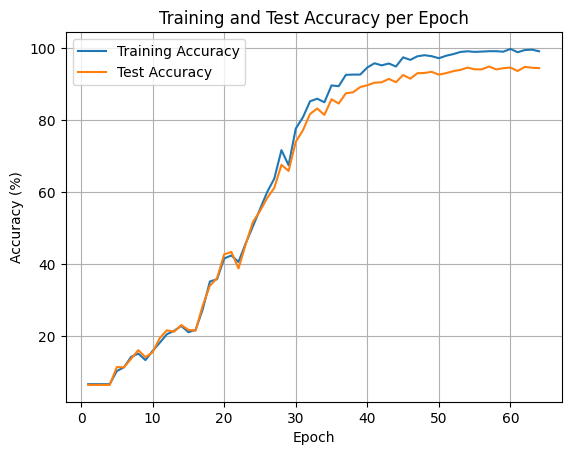

Epoch 65/100
Training Loss: 0.1540
Training Accuracy: 98.97%
Test Accuracy: 94.99%
Learning Rate: [0.01]


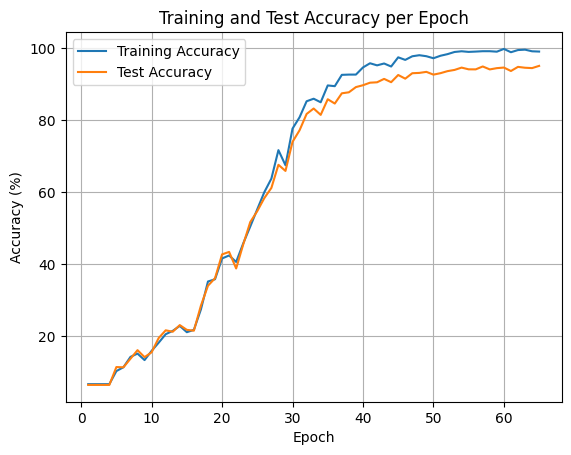

Epoch 66/100
Training Loss: 0.1499
Training Accuracy: 99.49%
Test Accuracy: 94.64%
Learning Rate: [0.01]


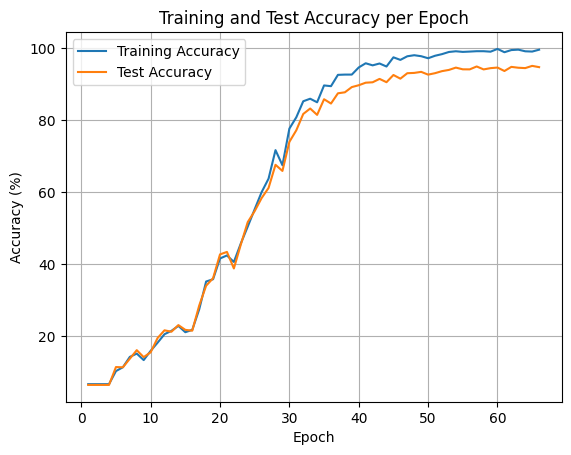

Epoch 67/100
Training Loss: 0.1460
Training Accuracy: 99.75%
Test Accuracy: 94.74%
Learning Rate: [0.01]


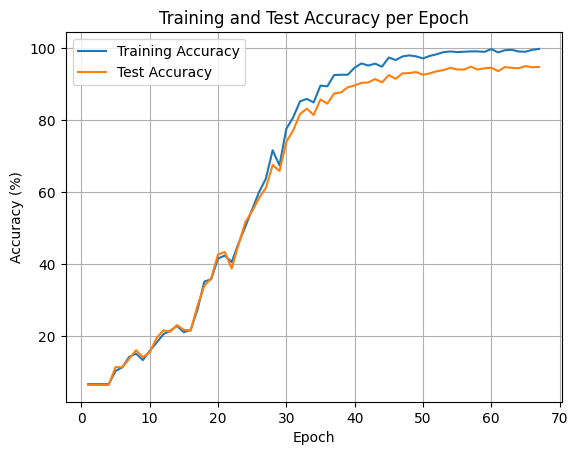

Epoch 68/100
Training Loss: 0.1370
Training Accuracy: 99.31%
Test Accuracy: 94.78%
Learning Rate: [0.01]


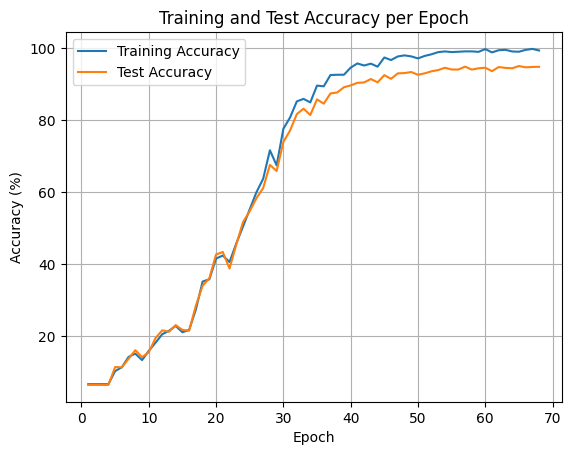

Epoch 69/100
Training Loss: 0.1390
Training Accuracy: 99.39%
Test Accuracy: 94.93%
Learning Rate: [0.01]


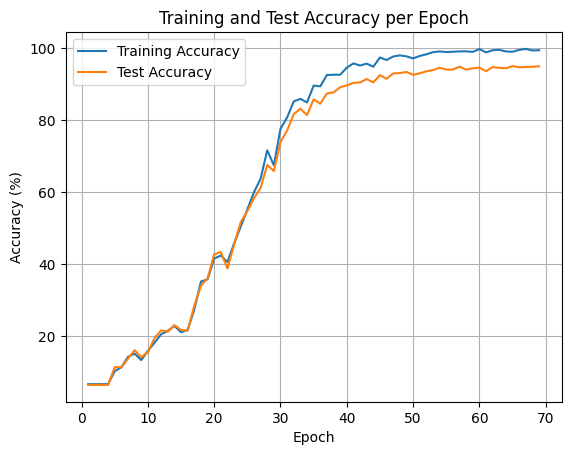

Epoch 70/100
Training Loss: 0.1363
Training Accuracy: 99.83%
Test Accuracy: 95.33%
Learning Rate: [0.01]


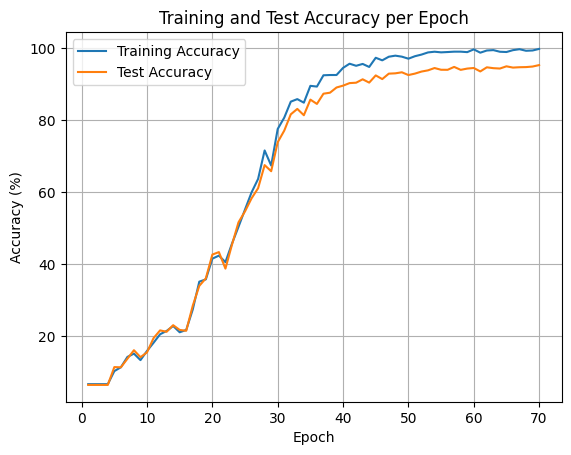

Epoch 71/100
Training Loss: 0.1256
Training Accuracy: 99.55%
Test Accuracy: 94.65%
Learning Rate: [0.01]


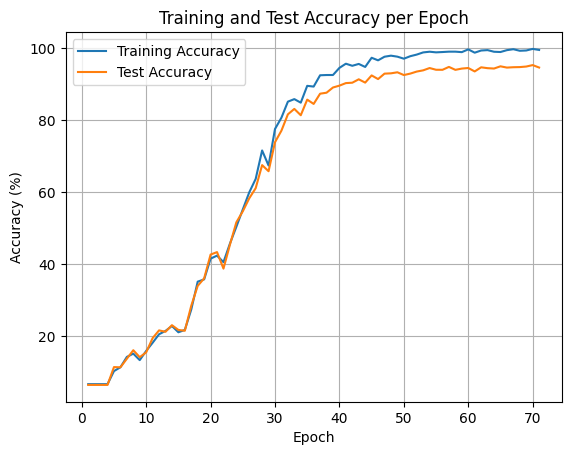

Epoch 72/100
Training Loss: 0.1253
Training Accuracy: 99.73%
Test Accuracy: 94.65%
Learning Rate: [0.01]


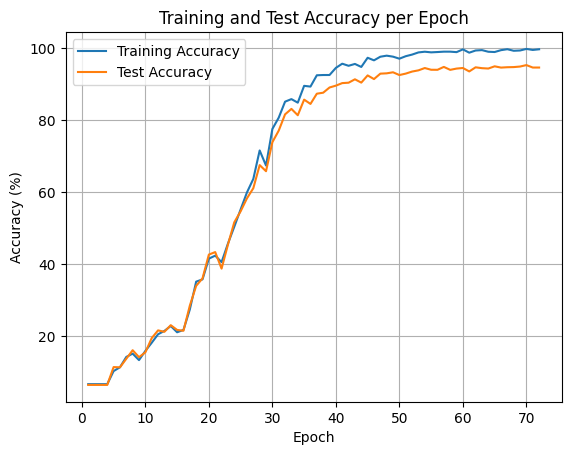

Epoch 73/100
Training Loss: 0.1202
Training Accuracy: 99.78%
Test Accuracy: 95.11%
Learning Rate: [0.01]


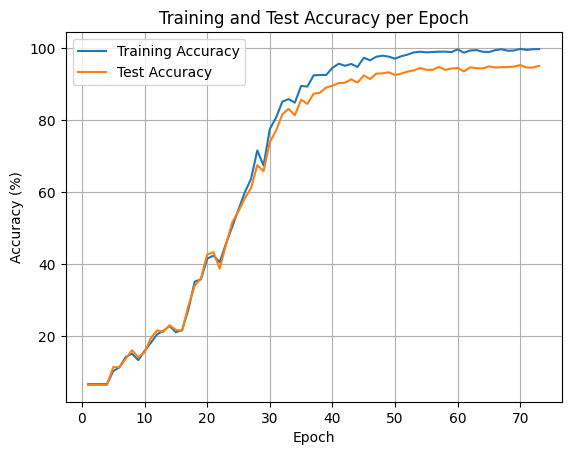

Epoch 74/100
Training Loss: 0.1216
Training Accuracy: 99.90%
Test Accuracy: 95.30%
Learning Rate: [0.01]


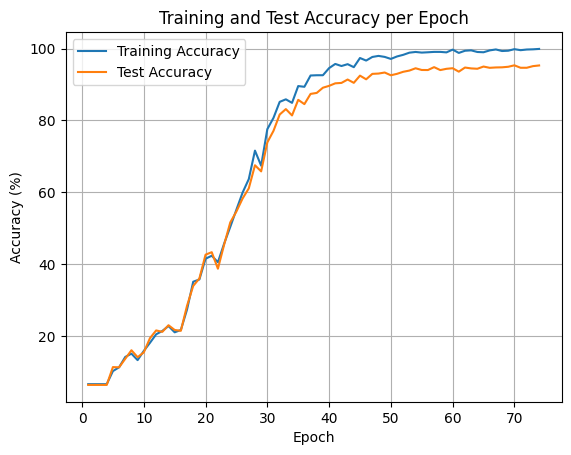

Epoch 75/100
Training Loss: 0.1242
Training Accuracy: 99.47%
Test Accuracy: 95.42%
Learning Rate: [0.01]


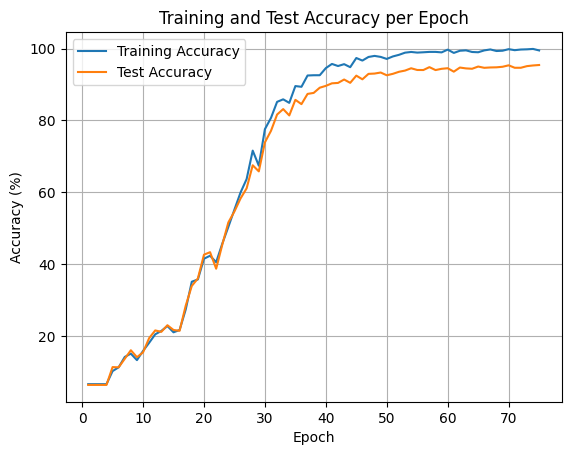

Epoch 76/100
Training Loss: 0.1119
Training Accuracy: 99.83%
Test Accuracy: 95.08%
Learning Rate: [0.01]


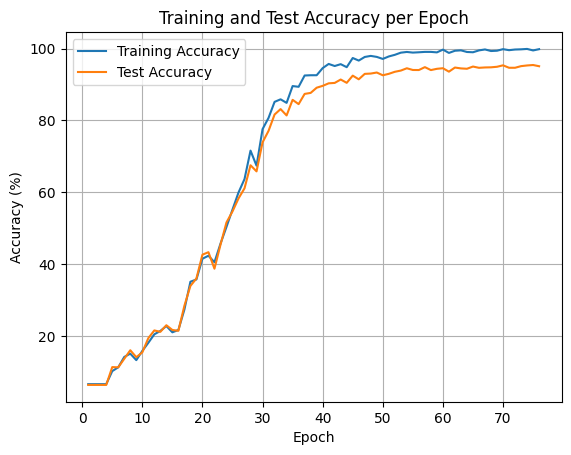

Epoch 77/100
Training Loss: 0.1095
Training Accuracy: 99.93%
Test Accuracy: 95.19%
Learning Rate: [0.01]


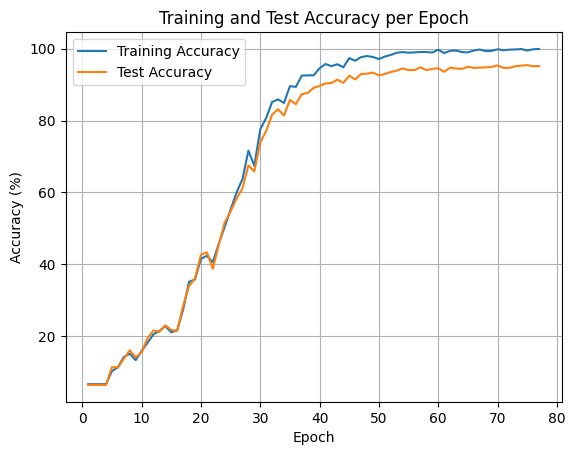

Epoch 78/100
Training Loss: 0.1141
Training Accuracy: 99.84%
Test Accuracy: 95.72%
Learning Rate: [0.01]


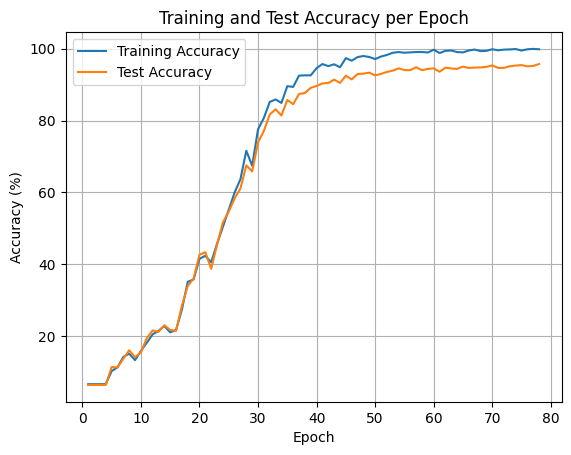

Epoch 79/100
Training Loss: 0.1048
Training Accuracy: 99.74%
Test Accuracy: 94.97%
Learning Rate: [0.01]


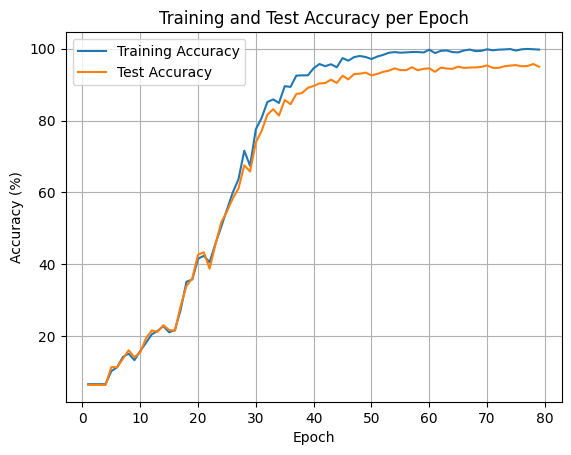

Epoch 80/100
Training Loss: 0.1013
Training Accuracy: 99.86%
Test Accuracy: 95.41%
Learning Rate: [0.01]


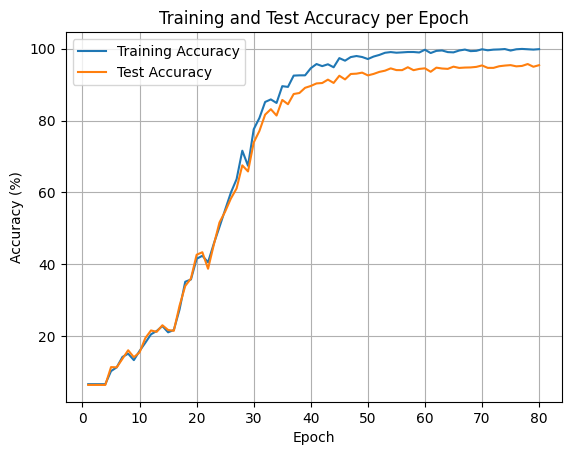

Epoch 81/100
Training Loss: 0.0976
Training Accuracy: 99.78%
Test Accuracy: 94.92%
Learning Rate: [0.01]


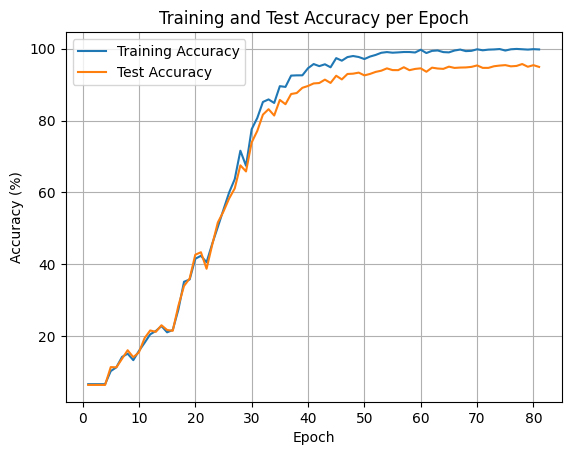

Epoch 82/100
Training Loss: 0.1004
Training Accuracy: 99.89%
Test Accuracy: 95.75%
Learning Rate: [0.01]


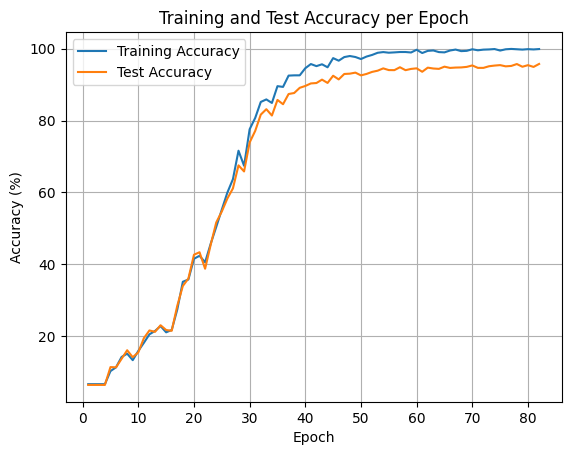

Epoch 83/100
Training Loss: 0.0992
Training Accuracy: 99.86%
Test Accuracy: 94.58%
Learning Rate: [0.01]


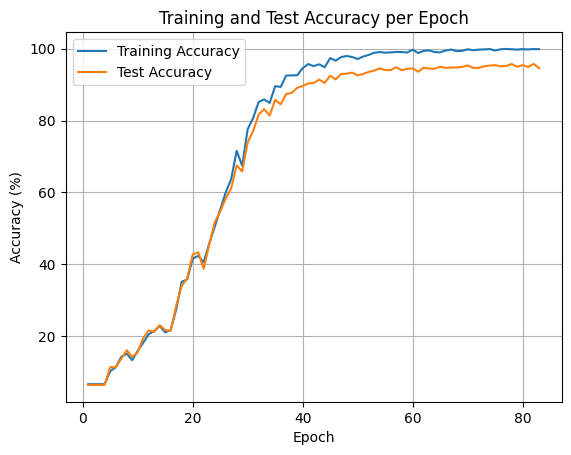

Epoch 84/100
Training Loss: 0.0948
Training Accuracy: 99.94%
Test Accuracy: 95.66%
Learning Rate: [0.01]


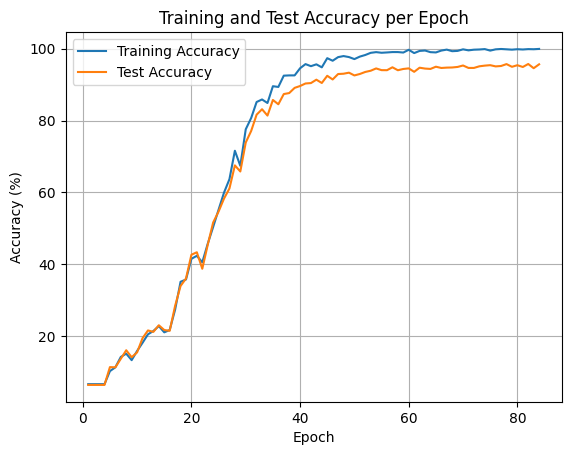

Epoch 85/100
Training Loss: 0.0942
Training Accuracy: 99.98%
Test Accuracy: 95.31%
Learning Rate: [0.01]


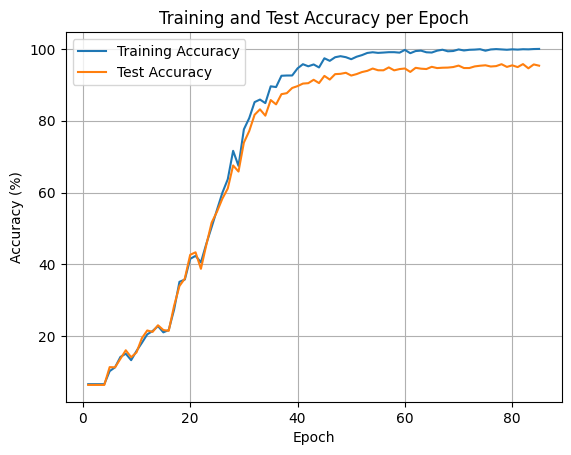

Epoch 86/100
Training Loss: 0.0906
Training Accuracy: 99.92%
Test Accuracy: 96.09%
Learning Rate: [0.01]


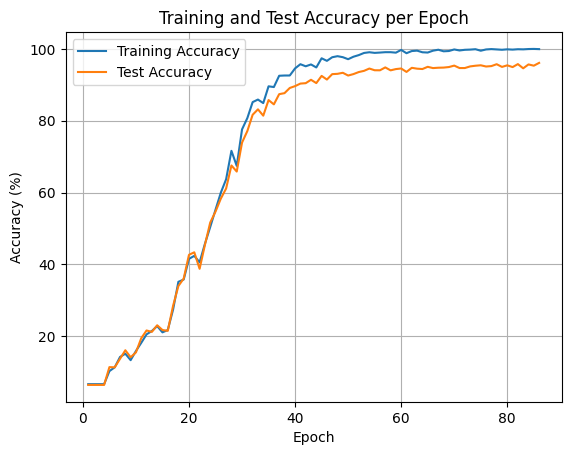

Epoch 87/100
Training Loss: 0.0921
Training Accuracy: 99.93%
Test Accuracy: 95.30%
Learning Rate: [0.01]


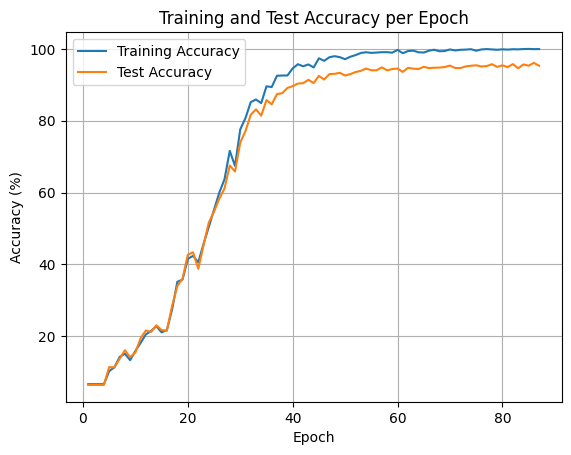

Epoch 88/100
Training Loss: 0.0839
Training Accuracy: 99.98%
Test Accuracy: 95.63%
Learning Rate: [0.009000000000000001]


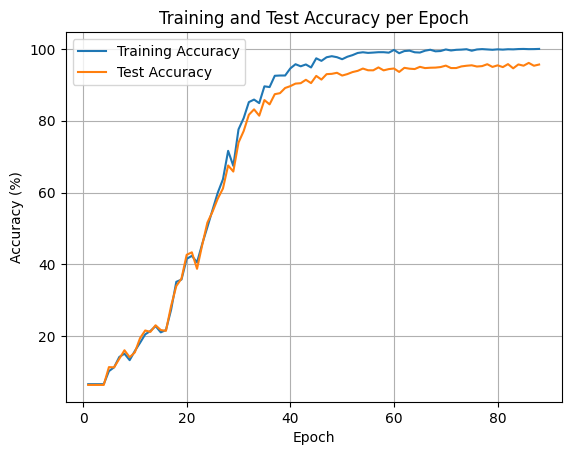

Epoch 89/100
Training Loss: 0.0848
Training Accuracy: 99.94%
Test Accuracy: 95.23%
Learning Rate: [0.009000000000000001]


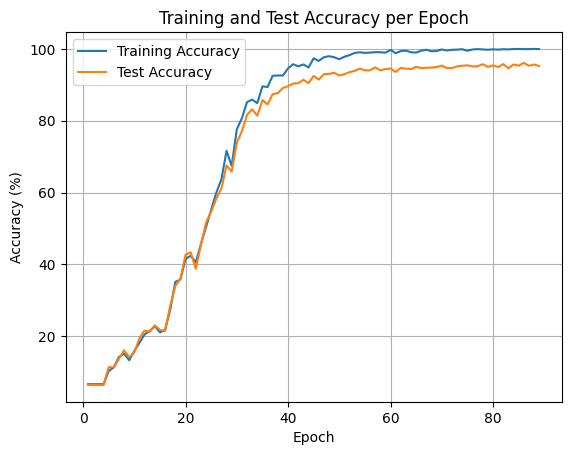

Epoch 90/100
Training Loss: 0.0822
Training Accuracy: 99.90%
Test Accuracy: 95.85%
Learning Rate: [0.009000000000000001]


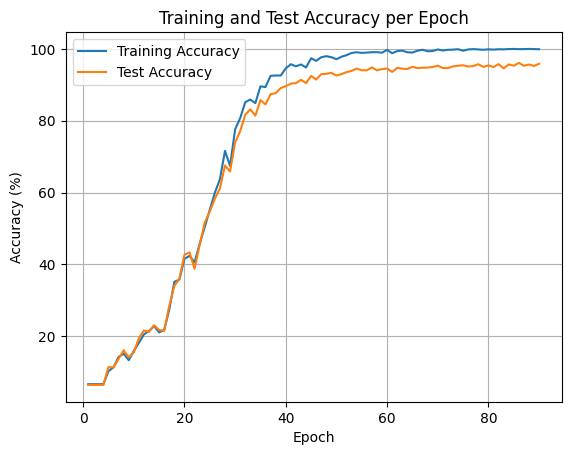

Epoch 91/100
Training Loss: 0.0773
Training Accuracy: 99.93%
Test Accuracy: 96.04%
Learning Rate: [0.009000000000000001]


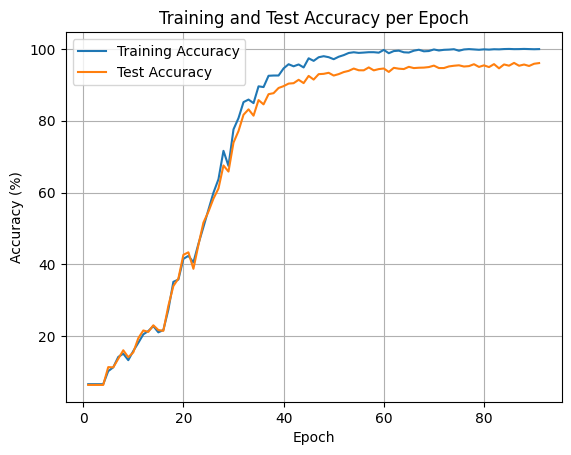

Epoch 92/100
Training Loss: 0.0778
Training Accuracy: 99.98%
Test Accuracy: 95.21%
Learning Rate: [0.009000000000000001]


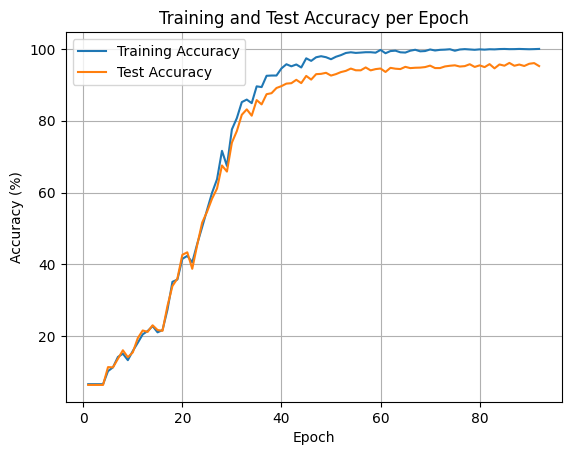

Epoch 93/100
Training Loss: 0.0745
Training Accuracy: 99.95%
Test Accuracy: 95.81%
Learning Rate: [0.009000000000000001]


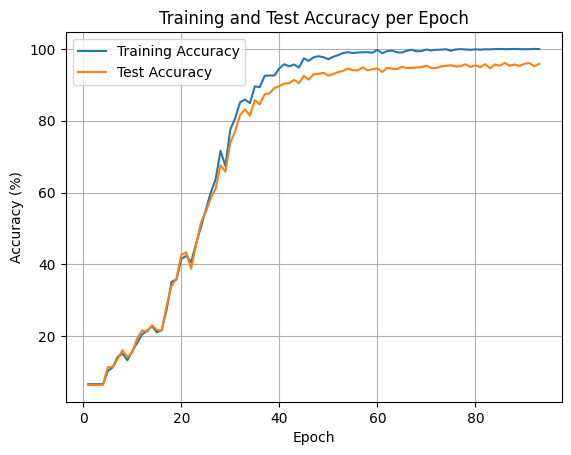

Epoch 94/100
Training Loss: 0.0765
Training Accuracy: 99.98%
Test Accuracy: 96.04%
Learning Rate: [0.009000000000000001]


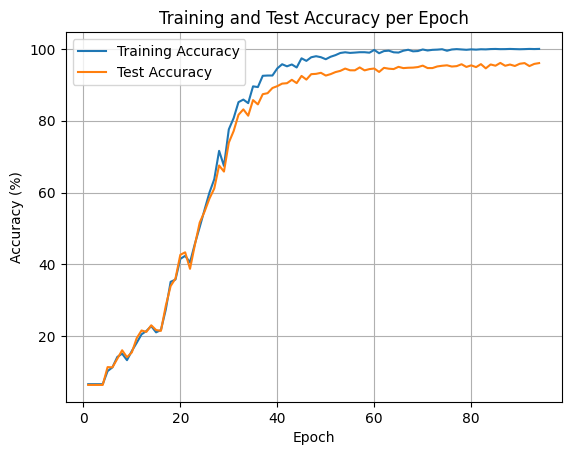

Epoch 95/100
Training Loss: 0.0684
Training Accuracy: 100.00%
Test Accuracy: 95.81%
Learning Rate: [0.009000000000000001]


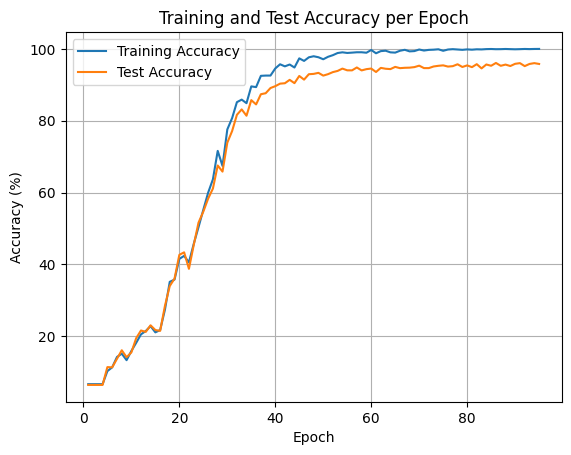

Epoch 96/100
Training Loss: 0.0742
Training Accuracy: 99.15%
Test Accuracy: 94.88%
Learning Rate: [0.009000000000000001]


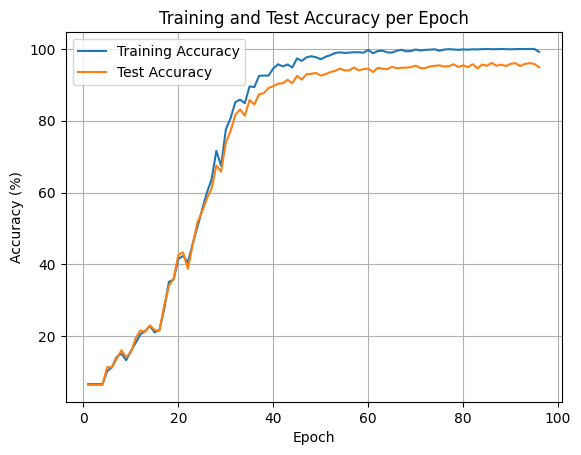

Epoch 97/100
Training Loss: 0.0763
Training Accuracy: 100.00%
Test Accuracy: 95.84%
Learning Rate: [0.009000000000000001]


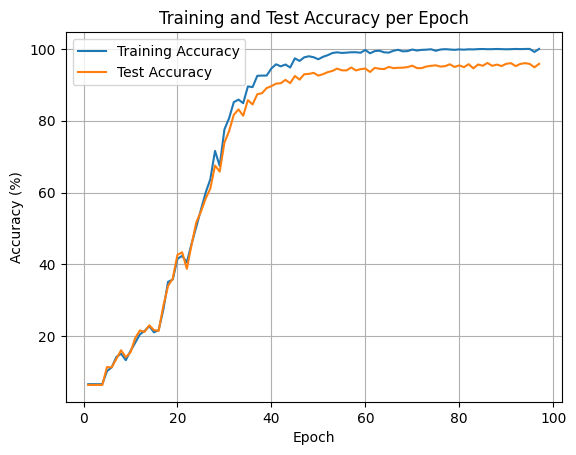

Epoch 98/100
Training Loss: 0.0690
Training Accuracy: 99.99%
Test Accuracy: 95.91%
Learning Rate: [0.009000000000000001]


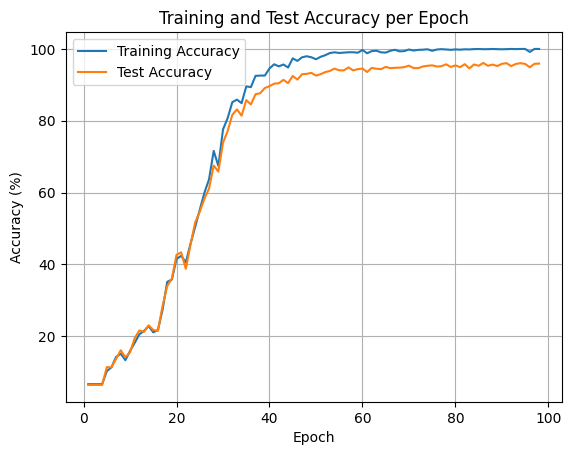

Epoch 99/100
Training Loss: 0.0691
Training Accuracy: 99.98%
Test Accuracy: 95.61%
Learning Rate: [0.009000000000000001]


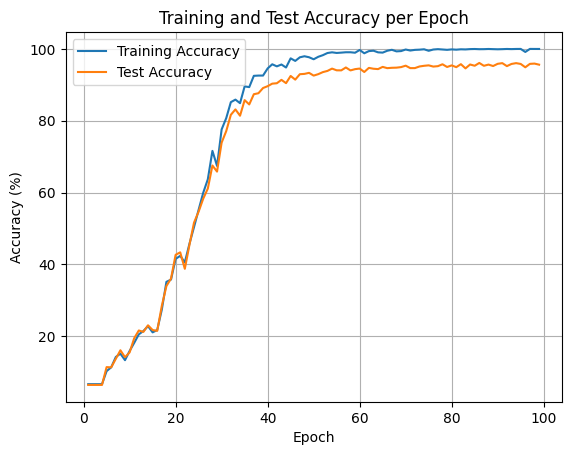

Epoch 100/100
Training Loss: 0.0667
Training Accuracy: 99.97%
Test Accuracy: 95.74%
Learning Rate: [0.008100000000000001]


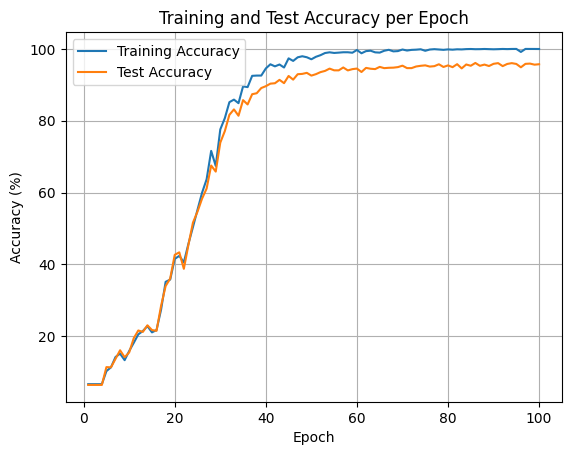

In [20]:
num_epochs = 100
train_accuracies = []
test_accuracies = []
train_losses = []

# Initialize the plot
plt.figure(figsize=(10, 6))

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train()
    running_loss = 0.0  # Track the loss for the current epoch

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(images)  # Forward pass
        loss = loss_func(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        running_loss += loss.item()  # Accumulate loss

    # Calculate average loss for the current epoch
    avg_loss = running_loss / len(train_loader)

    # Accuracy on training and test data
    train_accuracy = calculate_accuracy(model, train_loader, device)
    test_accuracy = calculate_accuracy(model, test_loader, device)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_losses.append(avg_loss)

    print(f"Training Loss: {avg_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.2f}%")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    current_lr =  scheduler.get_last_lr()
    print(f"Learning Rate: {current_lr}")
    
    
    # Step the scheduler to adjust learning rate based on validation loss (or training loss)
    scheduler.step(avg_loss)

    # Clear the current plot and update with new data
    plt.clf()  # Clear the figure
    plt.plot(range(1, epoch + 2), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epoch + 2), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Test Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    
    # Display the updated plot
    plt.pause(0.1)

# Save the model's weights
torch.save(model.state_dict(), 'model/60_epochs_with_lr_scheduler.pth')

# Show the final plot after all epochs
plt.show()

### Train Code from yt 
(https://www.youtube.com/watch?v=ZBfpkepdZlw)

In [32]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
		# load in the data in batches
    for i, (images, labels) in enumerate(train_loader):  
        # move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # forward propagation
        outputs = model(images)
        loss = loss_func(outputs, labels)
        
        # backward propagation and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # at end of epoch check validation loss and acc
    with torch.no_grad():
      	# switch model to eval (not train) model
        model.eval()
        correct = 0
        total = 0
        all_val_loss = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            total += labels.size(0)
            # calculate predictions
            predicted = torch.argmax(outputs, dim=1)
            # calculate actual values
            correct += (predicted == labels).sum().item()
            # calculate the loss
            all_val_loss.append(loss_func(outputs, labels).item())
        # calculate val-loss
        mean_val_loss = sum(all_val_loss) / len(all_val_loss)
        # calculate val-accuracy
        mean_val_acc = 100 * (correct / total)
    print(
        'Epoch [{}/{}], Loss: {:.4f}, Val-loss: {:.4f}, Val-acc: {:.1f}%'.format(
            epoch+1, num_epochs, loss.item(), mean_val_loss, mean_val_acc
        )
    )

Epoch [1/50], Loss: 0.0742, Val-loss: 0.1881, Val-acc: 96.3%
Epoch [2/50], Loss: 0.0709, Val-loss: 0.2043, Val-acc: 96.1%
Epoch [3/50], Loss: 0.0595, Val-loss: 0.2188, Val-acc: 96.0%
Epoch [4/50], Loss: 0.0823, Val-loss: 0.1963, Val-acc: 96.2%
Epoch [5/50], Loss: 0.0840, Val-loss: 0.1884, Val-acc: 96.5%
Epoch [6/50], Loss: 0.0433, Val-loss: 0.1581, Val-acc: 97.1%
Epoch [7/50], Loss: 0.1143, Val-loss: 0.2037, Val-acc: 96.5%
Epoch [8/50], Loss: 0.1236, Val-loss: 0.1939, Val-acc: 96.5%
Epoch [9/50], Loss: 0.0355, Val-loss: 0.1814, Val-acc: 96.9%
Epoch [10/50], Loss: 0.0245, Val-loss: 0.1774, Val-acc: 96.9%
Epoch [11/50], Loss: 0.0163, Val-loss: 0.1809, Val-acc: 97.2%
Epoch [12/50], Loss: 0.0102, Val-loss: 0.2030, Val-acc: 96.9%
Epoch [13/50], Loss: 0.0375, Val-loss: 0.2177, Val-acc: 96.7%
Epoch [14/50], Loss: 0.0171, Val-loss: 0.1690, Val-acc: 97.1%
Epoch [15/50], Loss: 0.0659, Val-loss: 0.1488, Val-acc: 97.2%
Epoch [16/50], Loss: 0.0492, Val-loss: 0.1581, Val-acc: 97.0%
Epoch [17/50], Lo

### Test the Model

In [33]:
def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the maximum value in the output
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Determine the device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the same device
model.to(device)
# Calculate accuracy on training data
train_accuracy = calculate_accuracy(model, train_loader, device)
print(f"Accuracy on training data: {train_accuracy:.2f}%")

# Calculate accuracy on test data
test_accuracy = calculate_accuracy(model, test_loader, device)
print(f"Accuracy on test data: {test_accuracy:.2f}%")


Accuracy on training data: 100.00%
Accuracy on test data: 97.50%


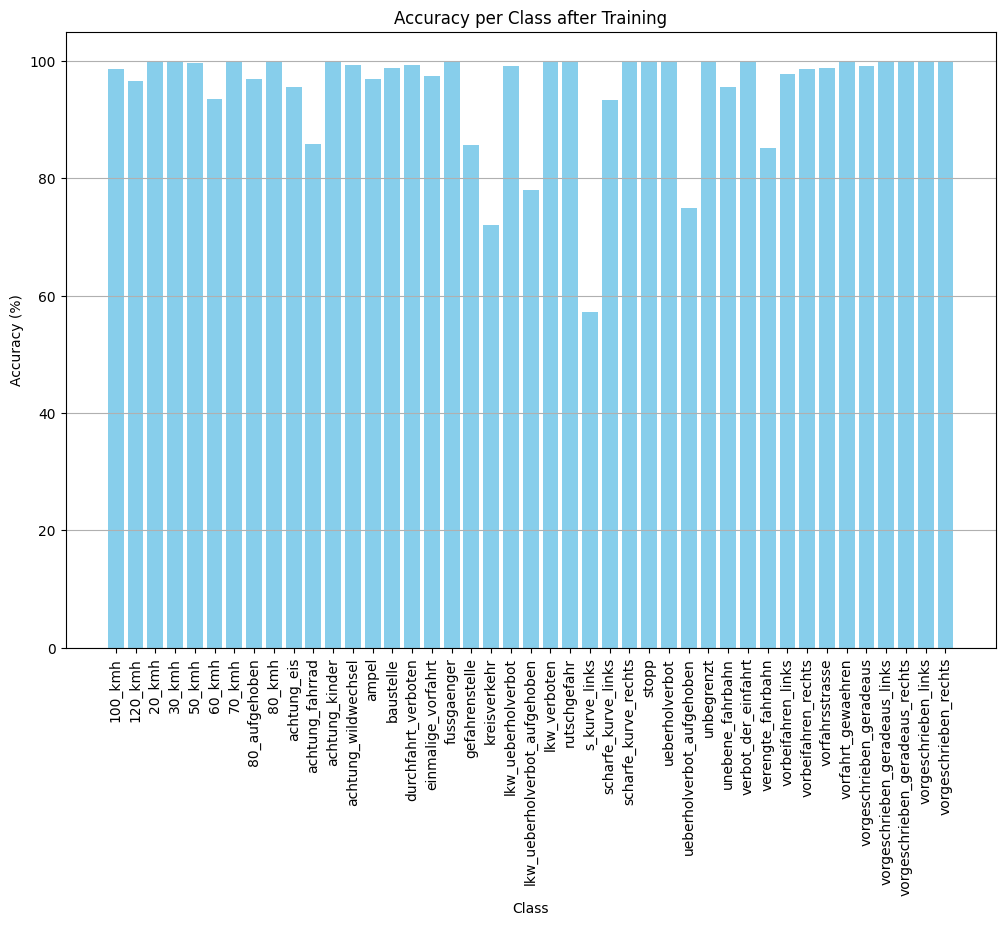

In [36]:
import torch
import matplotlib.pyplot as plt

# Berechnet die Accuracy pro Klasse, ohne die Anzahl der Klassen als Eingabe zu benötigen
def calculate_class_accuracy(model, data_loader, device):
    model.eval()
    
    # Hole die Anzahl der Klassen und die Klassennamen aus dem Dataset
    class_names = data_loader.dataset.classes
    num_classes = len(class_names)
    
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Sammle die Richtigkeit der Vorhersagen für jede Klasse
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i] == labels[i]:
                    class_correct[label] += 1
    
    # Berechne die Accuracy für jede Klasse
    class_accuracy = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_accuracy, class_names

# Berechne und plotte die Klassenaccuracy nach den 40 Trainingsepochen
class_accuracies, class_names = calculate_class_accuracy(model, test_loader, device)

# Plot Histogramm der Klassenaccuracies mit Klassennamen auf der x-Achse
plt.figure(figsize=(12, 8))
plt.bar(range(len(class_names)), class_accuracies, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Class after Training')
plt.xticks(range(len(class_names)), class_names, rotation=90)  # Setzt die Klassennamen als x-Achsen-Beschriftungen
plt.grid(axis='y')
plt.show()


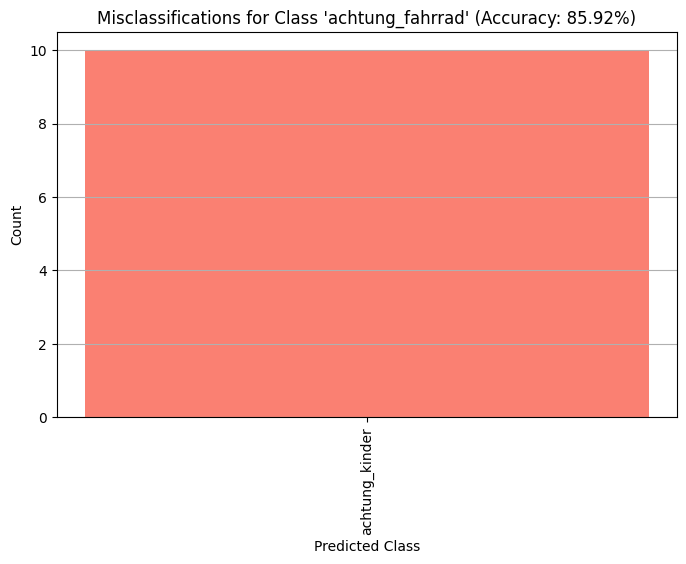

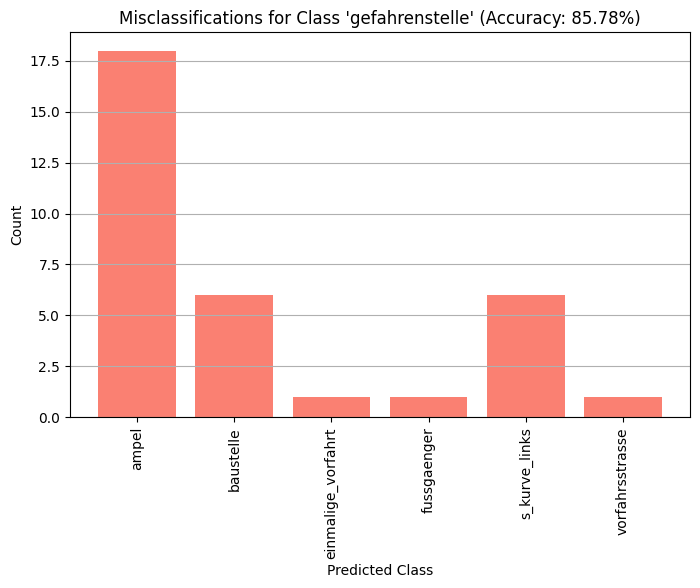

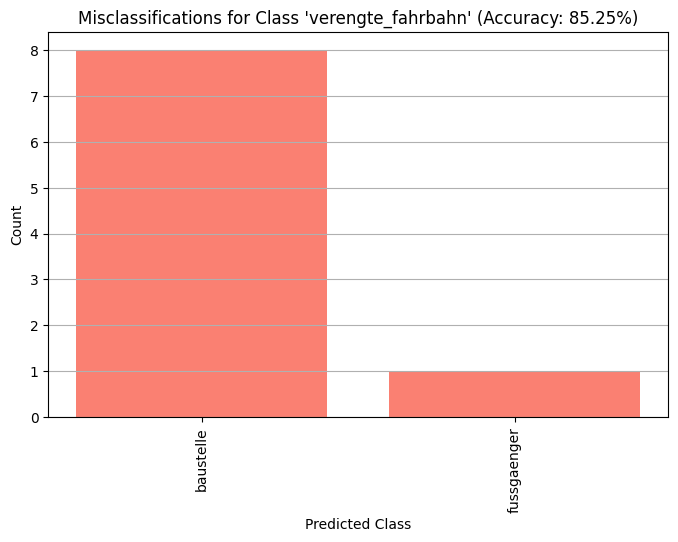

In [ ]:
import torch
import matplotlib.pyplot as plt
from collections import defaultdict

# Berechnet die Accuracy pro Klasse und speichert falsche Vorhersagen
def calculate_class_accuracy_and_misclassifications(model, data_loader, device):
    model.eval()
    
    # Hole die Anzahl der Klassen und die Klassennamen aus dem Dataset
    class_names = data_loader.dataset.classes
    num_classes = len(class_names)
    
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    misclassified_counts = defaultdict(lambda: [0] * num_classes)  # Zählt Fehlklassifizierungen je Klasse
    
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Zählt korrekte und fehlerhafte Vorhersagen
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i] == labels[i]:
                    class_correct[label] += 1
                else:
                    misclassified_counts[label][predicted[i].item()] += 1  # Fehlklassifizierung speichern
    
    # Berechne die Accuracy für jede Klasse
    class_accuracy = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_accuracy, class_names, misclassified_counts

# Berechne Accuracy und Fehlklassifizierungen
class_accuracies, class_names, misclassified_counts = calculate_class_accuracy_and_misclassifications(model, test_loader, device)

# Erstelle Plots für Klassen mit einer Accuracy < 80%
for i, accuracy in enumerate(class_accuracies):
    if accuracy < 90:
        # Bereite Daten für die Fehlklassifizierungen dieser Klasse auf
        misclassified_counts_for_class = misclassified_counts[i]
        misclassified_class_names = [class_names[j] for j in range(len(misclassified_counts_for_class)) if misclassified_counts_for_class[j] > 0]
        misclassified_class_counts = [misclassified_counts_for_class[j] for j in range(len(misclassified_counts_for_class)) if misclassified_counts_for_class[j] > 0]
        
        # Plot der Fehlklassifizierungen für die Klasse
        plt.figure(figsize=(8, 5))
        plt.bar(misclassified_class_names, misclassified_class_counts, color='salmon')
        plt.xlabel('Predicted Class')
        plt.ylabel('Count')
        plt.title(f"Misclassifications for Class '{class_names[i]}' (Accuracy: {accuracy:.2f}%)")
        plt.xticks(rotation=90)
        plt.grid(axis='y')
        plt.show()


#### If you want to test an old model, you can do this right here

Define the CNN Model Class vor Evaluation. Make sure you replace this with the correct Conv Layers and FC Layers of your trained model. 

In [28]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=4, padding=1)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=4, padding=1)
        self.relu3 = nn.ReLU()

        self.conv_layer4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=4, padding=1)
        self.relu4 = nn.ReLU()

        self.conv_layer5 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=4, padding=1)
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.dropout6 = nn.Dropout(p=0.5)
        
        
        self.fc6 = nn.Linear(128, 512) 
        self.relu6 = nn.ReLU()
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(512, 256)
        self.relu7 = nn.ReLU()

        self.dropout8 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(256, 128)
        self.relu8 = nn.ReLU()


        self.fc9 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)

        out = self.conv_layer2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)

        out = self.conv_layer3(out)
        out = self.relu3(out)

        out = self.conv_layer4(out)
        out = self.relu4(out)

        out = self.conv_layer5(out)
        out = self.relu5(out)
        out = self.max_pool5(out)

        out = out.reshape(out.size(0), -1)
        out = self.dropout6(out)
        out = self.fc6(out)
        out = self.relu6(out)

        out = self.dropout7(out)
        out = self.fc7(out)
        out = self.relu7(out)

        out = self.dropout8(out)
        out = self.fc8(out)
        out = self.relu8(out)

        out = self.fc9(out)

        return out

Provide now informations such as path and the number of output classes

In [29]:
model_path = 'model/base_sgd_model.pth'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Das Modell unter '{model_path}' wurde nicht gefunden.")

# Modell laden
trained_model = Net(num_classes=43)
trained_model.load_state_dict(torch.load(model_path))

C:\Users\v814u63\AppData\Local\Temp\ipykernel_24512\982607895.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

Now you can test your new model

In [31]:
def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the maximum value in the output
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Determine the device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the same device
trained_model.to(device)
# Calculate accuracy on training data
train_accuracy = calculate_accuracy(trained_model, train_loader, device)
print(f"Accuracy on training data: {train_accuracy:.2f}%")

# Calculate accuracy on test data
test_accuracy = calculate_accuracy(trained_model, test_loader, device)
print(f"Accuracy on test data: {test_accuracy:.2f}%")

Accuracy on training data: 98.35%
Accuracy on test data: 93.46%
